# Import Package

In [250]:
# Import essential packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb



In [251]:
# Import data from Github
eco_status = 'https://raw.githubusercontent.com/Kittisak-M/Bridging-the-Gap-Enhancing-Life-Quality-in-Thailand/main/data_set/Life%20Expectancy%20Data.csv'

main_data = 'https://raw.githubusercontent.com/Kittisak-M/Bridging-the-Gap-Enhancing-Life-Quality-in-Thailand/main/data_set/Data.csv'


In [252]:
# Read csv files
eco_status = pd.read_csv(eco_status)

data = pd.read_csv(main_data, encoding='latin-1')

In [253]:
# Drop duplicate
ct_status = eco_status[['Country', 'Status']].drop_duplicates().reindex()


In [254]:
# Change economics status to float
ct_status['Status'] = ct_status['Status'].replace('Developing',0)
ct_status['Status'] = ct_status['Status'].replace('Developed',1)


In [255]:
# Check the change
ct_status['Status'].unique()

array([0, 1])

In [256]:
# Count developed and developing countries
ct_status['Status'].value_counts()

,count
Status,
0,161
1,32


# Web Scraping Freedom Score

In [257]:
url = 'https://freedomhouse.org/countries/freedom-world/scores'

# Custom headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Make a request with the custom headers
response = requests.get(url, headers=headers)

# Check if request was successful
if response.status_code == 200:
    # Parse HTML content with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    tables = pd.read_html(str(soup))

    # Check if any tables were found
    if tables:
        # Select the first table (assuming it's the one you want)
        freedom_df = tables[0]

        print(freedom_df.head(5))

    else:
        print("No tables found in the HTML content.")
else:
    print(f"Failed to retrieve content: {response.status_code}")

  Country  Sort descending Total Score and Status  Political Rights  \
0                Abkhazia*         39 Partly Free                17   
1              Afghanistan             6 Not Free                 1   
2                  Albania         68 Partly Free                28   
3                  Algeria            32 Not Free                10   
4                  Andorra                93 Free                38   

   Civil Liberties  
0               22  
1                5  
2               40  
3               22  
4               55  


<ipython-input-257-1b12b5c9d676>:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(str(soup))


In [258]:
# Cleanse Data
freedom_df.columns = freedom_df.columns.str.lower()
freedom_df.columns = freedom_df.columns.str.replace(' ', '_')
freedom_df = freedom_df.rename(columns={'country__sort_descending': 'country_name','total_score_and_status':'freedom_status'})
freedom_df['total_freedom_score'] = freedom_df['political_rights'] + freedom_df['civil_liberties']
freedom_df['freedom_status'] = freedom_df['freedom_status'].str.replace('- Not Free','Not Free')
freedom_df['total_freedom_score'] = freedom_df['political_rights'] + freedom_df['civil_liberties']
freedom_df['freedom_status'] = freedom_df['freedom_status'].str.replace(r'\d+', '', regex=True).str.strip()
freedom_df['country_name'] = freedom_df['country_name'].str.replace('*','')

In [259]:
freedom_df.isna().sum()

,0
country_name,0
freedom_status,0
political_rights,0
civil_liberties,0
total_freedom_score,0


# DATA

In [260]:
eco_status.head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [261]:
# Drop null value in
data.dropna(subset=['Series Name'], inplace=True)

In [262]:
# Reshape dataframe
melted_data = data.melt(id_vars=['Series Name', 'Country Name', 'Country Code'],
                    var_name='Year',
                    value_name='Value')

# Extract the year from the column names
melted_data['Year'] = melted_data['Year'].str.extract('(\d{4})').astype(int)

In [263]:
melted_data['Series Name'].unique()

array(['Gini index', 'Access to electricity (% of population)',
       'Income share held by highest 10%',
       'Income share held by highest 20%',
       'Income share held by lowest 10%',
       'Income share held by lowest 20%',
       'Gross domestic income (constant LCU)',
       'Life expectancy at birth, total (years)',
       'Control of Corruption: Percentile Rank',
       'CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)',
       'Control of Corruption: Estimate',
       'Proportion of people living below 50 percent of median income (%)',
       'Poverty gap at $6.85 a day (2017 PPP) (%)',
       'Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)',
       'Population ages 0-14 (% of total population)',
       'Population ages 65 and above, total',
       'Population ages 15-64, total',
       'Consumer price index (2010 = 100)',
       'Inflation, consumer prices (annual %)', 'GDP (current US$)',
       'GDP g

In [264]:
melted_data.isnull().sum()

,0
Series Name,0
Country Name,128
Country Code,128
Year,0
Value,128


In [265]:
# Remove unnecessary rows
melted_data = melted_data.dropna(subset=['Country Name'])

In [266]:
melted_data

,Series Name,Country Name,Country Code,Year,Value
0,Gini index,Afghanistan,AFG,1960,..
1,Gini index,Albania,ALB,1960,..
2,Gini index,Algeria,DZA,1960,..
3,Gini index,American Samoa,ASM,1960,..
4,Gini index,Andorra,AND,1960,..
...,...,...,...,...,...
459769,High-technology exports (current US$),Sub-Saharan Africa,SSF,2023,..
459770,High-technology exports (current US$),Sub-Saharan Africa (excluding high income),SSA,2023,..
459771,High-technology exports (current US$),Sub-Saharan Africa (IDA & IBRD countries),TSS,2023,..
459772,High-technology exports (current US$),Upper middle income,UMC,2023,..


In [267]:
# Ensure all column names are strings
melted_data.columns = melted_data.columns.astype(str)

# Replace spaces with underscores in column names
melted_data.columns = melted_data.columns.str.replace(' ', '_')

# Lower text in column header
melted_data.columns = melted_data.columns.str.lower()


In [268]:
melted_data

,series_name,country_name,country_code,year,value
0,Gini index,Afghanistan,AFG,1960,..
1,Gini index,Albania,ALB,1960,..
2,Gini index,Algeria,DZA,1960,..
3,Gini index,American Samoa,ASM,1960,..
4,Gini index,Andorra,AND,1960,..
...,...,...,...,...,...
459769,High-technology exports (current US$),Sub-Saharan Africa,SSF,2023,..
459770,High-technology exports (current US$),Sub-Saharan Africa (excluding high income),SSA,2023,..
459771,High-technology exports (current US$),Sub-Saharan Africa (IDA & IBRD countries),TSS,2023,..
459772,High-technology exports (current US$),Upper middle income,UMC,2023,..


In [269]:
# Lower columns header
ct_status.columns = ct_status.columns.str.lower()

# Change col
ct_status = ct_status.rename(columns={'country':'country_name'})

# Join to get economy status
cleansed_data = pd.merge(melted_data,ct_status, how='left',on='country_name')

In [270]:
cleansed_data.loc[(cleansed_data['series_name'] == 'Gini index') & (cleansed_data['country_name'] == 'Andorra') & (cleansed_data['year'] == 1960)]

,series_name,country_name,country_code,year,value,status
4,Gini index,Andorra,AND,1960,..,NaN


## Machine Learning to fill Economics Status

## Create a pick a list that are not countries

In [271]:
c_list = data['Country Name'].unique().copy()

not_countries = [
    'American Samoa', 'Bermuda', 'British Virgin Islands', 'Cayman Islands',
    'Channel Islands', 'Curaçao', 'Faroe Islands', 'French Polynesia', 'Gibraltar',
    'Greenland', 'Guam', 'Isle of Man',
    'Marshall Islands', 'Monaco', 'New Caledonia', 'Northern Mariana Islands',
    'Puerto Rico', 'Sint Maarten (Dutch part)', 'St. Martin (French part)', 'Turks and Caicos Islands',
    'Virgin Islands (U.S.)', 'West Bank and Gaza', 'Africa Eastern and Southern', 'Africa Western and Central',
    'Arab World', 'Caribbean small states', 'Central Europe and the Baltics', 'Early-demographic dividend',
    'East Asia & Pacific', 'East Asia & Pacific (excluding high income)', 'East Asia & Pacific (IDA & IBRD countries)',
    'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (excluding high income)',
    'Europe & Central Asia (IDA & IBRD countries)', 'European Union', 'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend',
    'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)', 'Latin America & the Caribbean (IDA & IBRD countries)',
    'Least developed countries: UN classification', 'Low & middle income', 'Low income', 'Lower middle income',
    'Middle East & North Africa', 'Middle East & North Africa (excluding high income)',
    'Middle East & North Africa (IDA & IBRD countries)', 'Middle income', 'North America', 'Not classified',
    'OECD members', 'Other small states', 'Pacific island small states', 'Post-demographic dividend',
    'Pre-demographic dividend', 'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa',
    'Sub-Saharan Africa (excluding high income)', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
    'World'
]

len(not_countries)

71

## Split index table

In [272]:
index_names = cleansed_data['series_name'].unique()

In [273]:
#Get unique values in 'series_name' column
unique_series_names = cleansed_data['series_name'].unique()

series_dataframes = {}

for series_name in unique_series_names:
    # Filter the DataFrame for the current series_name
    series_df = cleansed_data[~cleansed_data['country_name'].isin(not_countries)]
    series_df = series_df[series_df['year'] == 2022]
    series_df = series_df[series_df['series_name'] == series_name]

    # Store the DataFrame in the dictionary
    series_dataframes[series_name] = series_df


In [274]:
# Create individual dataframe
def create_individual_dataframes(series_dataframes):
    for key, df in series_dataframes.items():
        formatted_name = key.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('%', 'percent').replace('$', 'usd').replace('=', 'equals').replace('-', '_').lower()
        globals()[formatted_name] = df

        # Replace spaces with underscores in the entire DataFrame
        df.columns = [col.replace(' ', '_').lower() for col in df.columns]
        for col in df.columns:
            df[col] = df[col].apply(lambda x: x.replace(' ', '_') if isinstance(x, str) else x)

# Call the function to create the individual DataFrames
create_individual_dataframes(series_dataframes)


In [275]:
# Display all created dataframes
for key in series_dataframes.keys():
    formatted_name = key.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('%', 'percent').replace('$', 'usd').replace('=', 'equals').replace('-', '_').lower()
    print(f"\nDataFrame: {formatted_name}")


DataFrame: gini_index

DataFrame: access_to_electricity_percent_of_population

DataFrame: income_share_held_by_highest_10percent

DataFrame: income_share_held_by_highest_20percent

DataFrame: income_share_held_by_lowest_10percent

DataFrame: income_share_held_by_lowest_20percent

DataFrame: gross_domestic_income_constant_lcu

DataFrame: life_expectancy_at_birth_total_years

DataFrame: control_of_corruption:_percentile_rank

DataFrame: cpia_transparency_accountability_and_corruption_in_the_public_sector_rating_1equalslow_to_6equalshigh

DataFrame: control_of_corruption:_estimate

DataFrame: proportion_of_people_living_below_50_percent_of_median_income_percent

DataFrame: poverty_gap_at_usd6.85_a_day_2017_ppp_percent

DataFrame: poverty_headcount_ratio_at_usd6.85_a_day_2017_ppp_percent_of_population

DataFrame: population_ages_0_14_percent_of_total_population

DataFrame: population_ages_65_and_above_total

DataFrame: population_ages_15_64_total

DataFrame: consumer_price_index_2010_equa

In [276]:
print(len(gini_index['country_code'].unique()))

196


In [277]:
# Count missing values in each series_dataframes
for key in series_dataframes.keys():
    formatted_name = key.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('%', 'percent').replace('$', 'usd').replace('=', 'equals').replace('-', '_').lower()
    missing_count = series_dataframes[key]['value'].value_counts().get('..',0)
    print(f"\nDataFrame: {formatted_name}")
    print(f"Missing Value Count: {missing_count}")


DataFrame: gini_index
Missing Value Count: 172

DataFrame: access_to_electricity_percent_of_population
Missing Value Count: 1

DataFrame: income_share_held_by_highest_10percent
Missing Value Count: 172

DataFrame: income_share_held_by_highest_20percent
Missing Value Count: 172

DataFrame: income_share_held_by_lowest_10percent
Missing Value Count: 172

DataFrame: income_share_held_by_lowest_20percent
Missing Value Count: 172

DataFrame: gross_domestic_income_constant_lcu
Missing Value Count: 46

DataFrame: life_expectancy_at_birth_total_years
Missing Value Count: 4

DataFrame: control_of_corruption:_percentile_rank
Missing Value Count: 1

DataFrame: cpia_transparency_accountability_and_corruption_in_the_public_sector_rating_1equalslow_to_6equalshigh
Missing Value Count: 123

DataFrame: control_of_corruption:_estimate
Missing Value Count: 1

DataFrame: proportion_of_people_living_below_50_percent_of_median_income_percent
Missing Value Count: 172

DataFrame: poverty_gap_at_usd6.85_a_day_

In [278]:
# Iterate through keys (column headers)
for column_header in series_dataframes.keys():
    # Modify column header
    modified_header = column_header.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '').replace('%', 'percent').replace('$', 'usd').replace('=', 'equals').replace('-', '_').lower()

    # Rename the corresponding column in the DataFrame
    series_dataframes[column_header] = series_dataframes[column_header].rename(columns={'value': modified_header})

# Print modified DataFrames to verify
for column_header, df in series_dataframes.items():
    print(f"\nDataFrame: {column_header}")




DataFrame: Gini index

DataFrame: Access to electricity (% of population)

DataFrame: Income share held by highest 10%

DataFrame: Income share held by highest 20%

DataFrame: Income share held by lowest 10%

DataFrame: Income share held by lowest 20%

DataFrame: Gross domestic income (constant LCU)

DataFrame: Life expectancy at birth, total (years)

DataFrame: Control of Corruption: Percentile Rank

DataFrame: CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)

DataFrame: Control of Corruption: Estimate

DataFrame: Proportion of people living below 50 percent of median income (%)

DataFrame: Poverty gap at $6.85 a day (2017 PPP) (%)

DataFrame: Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)

DataFrame: Population ages 0-14 (% of total population)

DataFrame: Population ages 65 and above, total

DataFrame: Population ages 15-64, total

DataFrame: Consumer price index (2010 = 100)

DataFrame: Inflation, consumer prices 

In [279]:
# Get a list of DataFrame keys
keys = list(series_dataframes.keys())

# Initialize the merged DataFrame with the first DataFrame in the dictionary
merged_df = series_dataframes[keys[0]].copy()

# Loop through the remaining DataFrames in the dictionary and merge them using a left join
for key in keys[1:]:
    # Rename columns in the DataFrame to be merged
    series_dataframes[key].rename(columns={col: f"{col}_{key}" for col in series_dataframes[key].columns if col != 'country_code'}, inplace=True)

    # Merge with the existing merged DataFrame
    merged_df = pd.merge(merged_df, series_dataframes[key], on='country_code', how='left')

    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

In [280]:
# Create list to filter important column in the merged_df
result_list = [1,2,5]

for i in range(4,136,5):
     result_list.append(i)


In [281]:
feature_eng = merged_df.iloc[:, result_list]
feature_eng.columns = feature_eng.columns.str.lower()
feature_eng.columns = feature_eng.columns.str.replace(' ', '_')
feature_eng = feature_eng.replace('..', np.nan)

In [282]:
feature_eng.filter(like='life')

,"life_expectancy_at_birth_total_years_life_expectancy_at_birth,_total_(years)"
0,62.879
1,76.833
2,77.129
3,NaN
4,61.929
...,...
191,71.105
192,74.58
193,63.72
194,61.803


In [283]:
for idx, col in enumerate(feature_eng.columns):
    nan_count = feature_eng[col].isna().sum()  # Count NaN values in each column
    nan_info = "Contains NaN" if nan_count > 0 else "No NaN"
    print(f"Index {idx} | {nan_count} null value | {col}")

Index 0 | 0 null value | country_name
Index 1 | 0 null value | country_code
Index 2 | 33 null value | status
Index 3 | 172 null value | gini_index
Index 4 | 1 null value | access_to_electricity_percent_of_population_access_to_electricity_(%_of_population)
Index 5 | 172 null value | income_share_held_by_highest_10percent_income_share_held_by_highest_10%
Index 6 | 172 null value | income_share_held_by_highest_20percent_income_share_held_by_highest_20%
Index 7 | 172 null value | income_share_held_by_lowest_10percent_income_share_held_by_lowest_10%
Index 8 | 172 null value | income_share_held_by_lowest_20percent_income_share_held_by_lowest_20%
Index 9 | 46 null value | gross_domestic_income_constant_lcu_gross_domestic_income_(constant_lcu)
Index 10 | 4 null value | life_expectancy_at_birth_total_years_life_expectancy_at_birth,_total_(years)
Index 11 | 1 null value | control_of_corruption:_percentile_rank_control_of_corruption:_percentile_rank
Index 12 | 123 null value | cpia_transparency_a

In [284]:
columns_with_fewer_nans = []

# Iterate through each column in the DataFrame
for col in feature_eng.columns:
    nan_count = feature_eng[col].isna().sum()  # Count NaN values in the column
    if nan_count < 80:  # Check if the number of NaN values is fewer than 80
        columns_with_fewer_nans.append(col)  # Append the column name to the list

# Create a new DataFrame with only the columns that have fewer than 80 NaN values
feature_eng2 = feature_eng[columns_with_fewer_nans]

In [285]:
# Shorten columns header name
name_change = {
    'country_name': 'country_name',
    'country_code': 'country_code',
    'status': 'status',
    'access_to_electricity_percent_of_population_access_to_electricity_(%_of_population)': 'access_to_electricity',
    'gross_domestic_income_constant_lcu_gross_domestic_income_(constant_lcu)': 'gross_domestic_income',
    'life_expectancy_at_birth_total_years_life_expectancy_at_birth,_total_(years)': 'life_expectancy',
    'control_of_corruption:_percentile_rank_control_of_corruption:_percentile_rank': 'control_of_corruption_percentile',
    'control_of_corruption:_estimate_control_of_corruption:_estimate': 'control_of_corruption_estimate',
    'population_ages_0_14_percent_of_total_population_population_ages_0-14_(%_of_total_population)': 'population_0_14%',
    'population_ages_65_and_above_total_population_ages_65_and_above,_total': 'population_65_above_total',
    'population_ages_15_64_total_population_ages_15-64,_total': 'population_15_64_total',
    'consumer_price_index_2010_equals_100_consumer_price_index_(2010_=_100)': 'consumer_price_index_2010',
    'inflation_consumer_prices_annual_percent_inflation,_consumer_prices_(annual_%)': 'inflation_annual%',
    'gdp_current_ususd_gdp_(current_us$)': 'gdp_current_usd',
    'gdp_growth_annual_percent_gdp_growth_(annual_%)': 'gdp_growth_annual%',
    'gdp_per_capita_current_ususd_gdp_per_capita_(current_us$)': 'gdp_per_capita_current_usd',
    'imports_of_goods_and_services_percent_of_gdp_imports_of_goods_and_services_(%_of_gdp)': 'imports_%gdp',
    'military_expenditure_percent_of_gdp_military_expenditure_(%_of_gdp)': 'military_expenditure_%gdp',
    'high_technology_exports_current_ususd_high-technology_exports_(current_us$)': 'high_technology_exports_usd'
}

# Rename columns
feature_eng2.rename(columns=name_change, inplace=True)

<ipython-input-285-d8d44d1ec8cd>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_eng2.rename(columns=name_change, inplace=True)


In [286]:
convert_numer = feature_eng2.iloc[:, 3:].columns
for col in convert_numer:
    feature_eng2[col] = feature_eng2[col] = pd.to_numeric(feature_eng2[col], errors='coerce')

<ipython-input-286-696f6e2a77f4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_eng2[col] = feature_eng2[col] = pd.to_numeric(feature_eng2[col], errors='coerce')


In [287]:
# Change number format
col_to_change = ['gross_domestic_income','gdp_current_usd','high_technology_exports_usd']

for col in col_to_change:
    feature_eng2[col] = feature_eng2[col].apply(lambda x: int(float(x)) if not pd.isnull(x) else x)


<ipython-input-287-ffa40007471d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_eng2[col] = feature_eng2[col].apply(lambda x: int(float(x)) if not pd.isnull(x) else x)


In [288]:
feature_eng2.dtypes

,0
country_name,object
country_code,object
status,float64
access_to_electricity,float64
gross_domestic_income,float64
life_expectancy,float64
control_of_corruption_percentile,float64
control_of_corruption_estimate,float64
population_0_14%,float64
population_65_above_total,int64


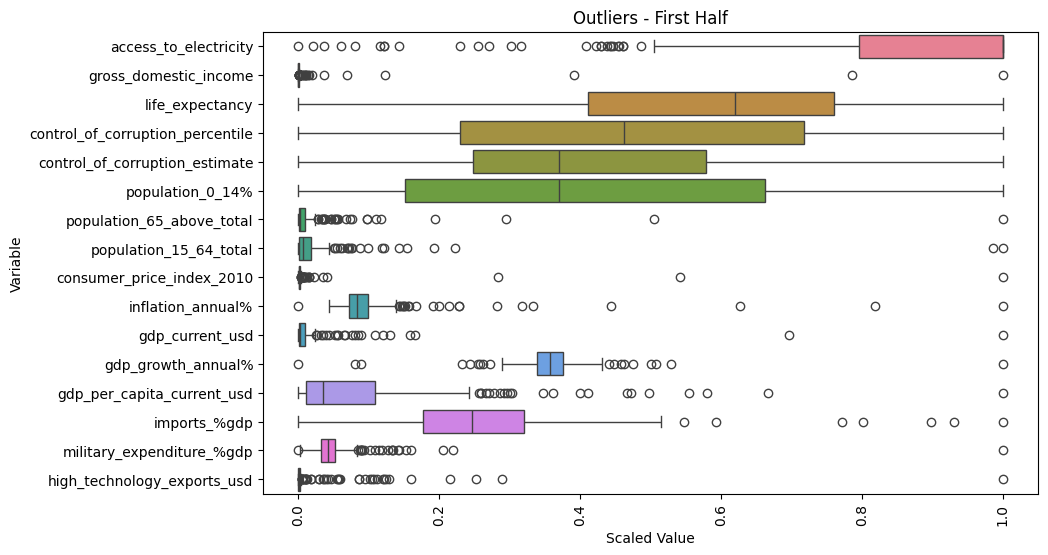

In [289]:
# Fill missing values
feature_eng2_filled = feature_eng2.iloc[:, 3:].fillna(feature_eng2.iloc[:, 3:].median())

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(feature_eng2_filled)

# Create a DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=feature_eng2_filled.columns)

# Split the DataFrame into two parts
mid_index = len(scaled_df.columns)
first_half = scaled_df.columns[:mid_index]
second_half = scaled_df.columns[mid_index:]

# Create first figure for the first half
plt.figure(figsize=(10, 6))
sns.boxplot(data=scaled_df[first_half], orient='h')
plt.title('Outliers - First Half')
plt.xlabel('Scaled Value')
plt.ylabel('Variable')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

##  

## Find missing country

In [290]:
data['Country Code'].unique()

array(['AFG', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'ATG', 'ARG', 'ARM',
       'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR',
       'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BIH', 'BWA', 'BRA',
       'VGB', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN',
       'CYM', 'CAF', 'TCD', 'CHI', 'CHL', 'CHN', 'COL', 'COM', 'COD',
       'COG', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK',
       'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST',
       'SWZ', 'ETH', 'FRO', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GUM', 'GTM',
       'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'HKG', 'HUN', 'ISL', 'IND',
       'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN',
       'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'XKX', 'KWT', 'KGZ',
       'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX',
       'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MRT',
       'MUS', 'MEX',

In [291]:
feature_eng2 = feature_eng2.round(2)

In [292]:
feature_eng2

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,population_15_64_total,consumer_price_index_2010,inflation_annual%,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd
0,Afghanistan,AFG,0.0,85.3,1.010000e+12,62.88,12.26,-1.18,43.13,984763,22404909,NaN,NaN,1.450216e+10,-6.24,352.60,54.51,NaN,NaN
1,Albania,ALB,0.0,100.0,1.770000e+12,76.83,38.68,-0.41,16.15,462629,1866557,131.75,6.73,1.891638e+10,4.86,6810.11,47.75,1.58,8.864110e+05
2,Algeria,DZA,0.0,100.0,2.640000e+13,77.13,28.30,-0.64,30.64,2868322,28275097,181.62,9.27,2.260000e+11,3.60,5023.25,20.39,4.78,NaN
3,Andorra,AND,NaN,100.0,NaN,NaN,88.68,1.27,12.80,11948,57663,NaN,NaN,3.380602e+09,9.56,42350.70,NaN,NaN,4.339834e+07
4,Angola,AGO,0.0,48.5,1.470000e+12,61.93,30.66,-0.60,45.02,925334,18643225,708.32,21.36,1.040000e+11,3.05,2933.48,25.30,1.33,7.720446e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,"Venezuela,_RB",VEN,NaN,100.0,NaN,71.10,1.89,-1.65,27.57,2436358,18061363,NaN,NaN,NaN,NaN,NaN,NaN,0.65,NaN
192,Viet_Nam,VNM,0.0,100.0,5.820000e+15,74.58,45.75,-0.29,22.39,8951655,67251030,177.31,3.16,4.100000e+11,8.12,4179.01,89.98,NaN,1.230000e+11
193,"Yemen,_Rep.",YEM,NaN,76.0,NaN,63.72,1.42,-1.68,39.50,897081,19490300,NaN,NaN,NaN,NaN,698.85,NaN,NaN,NaN
194,Zambia,ZMB,0.0,47.8,NaN,61.80,34.43,-0.53,42.86,349807,11088982,332.78,10.99,2.916378e+10,5.25,1456.90,29.10,1.19,1.123747e+07


## EDA

In [293]:
# Developed Country
feature_eng2[feature_eng2['status'] == 1].nunique()

,0
country_name,29
country_code,29
status,1
access_to_electricity,1
gross_domestic_income,29
life_expectancy,28
control_of_corruption_percentile,29
control_of_corruption_estimate,28
population_0_14%,29
population_65_above_total,29


In [294]:
# Developing Country
dev_ing_c = feature_eng2[feature_eng2['status'] == 0]

# Developed Country
dev_ed_c = feature_eng2[feature_eng2['status'] == 1]

In [295]:
def calculate_percentage(dev_countries, ing_countries):
    total_countries = dev_countries + ing_countries
    percentage_dev = (dev_countries / total_countries) * 100
    percentage_ing = (ing_countries / total_countries) * 100
    return round(percentage_dev,2), round(percentage_ing,2)

dev_countries_count = dev_ed_c['country_code'].nunique()
ing_countries_count = dev_ing_c['country_code'].nunique()

# Calculate percentages
dev_percentage, ing_percentage = calculate_percentage(dev_countries_count, ing_countries_count)

# Print results using formatted strings
print(f"Dataset percentage:\nDeveloped Country: {dev_percentage}%\nDeveloping Country: {ing_percentage}%")


Dataset percentage:
Developed Country: 17.79%
Developing Country: 82.21%


In [296]:
# Upsampling to 50:50

In [297]:
feature_eng2.isna().sum()

,0
country_name,0
country_code,0
status,33
access_to_electricity,1
gross_domestic_income,46
life_expectancy,4
control_of_corruption_percentile,1
control_of_corruption_estimate,1
population_0_14%,0
population_65_above_total,0


In [298]:
# Fill missing value based on economics status
# Explanation of the rules:
# - Calculate mean values separately for rows where 'status' is 0 (developing) and 1 (developed), and overall mean for the column.
# - Use apply() with a lambda function to fill missing values in each row (row[col_name]):
#   - If 'status' is 1 and the value is missing, fill with average DEVELOPED country in each column.
#   - If 'status' is 0 and the value is missing, fill with average DEVELOPING country in each column.
#   - If 'status' is missing (pd.isna(row['status'])) and the value is missing, fill with average OVERALL country.

for col_name in feature_eng2.columns:
    if col_name not in ['country_name','country_code','status']:  # Skip the status column itself
        mean_A_status0 = feature_eng2[feature_eng2['status'] == 0][col_name].median()
        mean_A_status1 = feature_eng2[feature_eng2['status'] == 1][col_name].median()
        mean_A_status_ms = feature_eng2[col_name].median()

        feature_eng2[col_name] = feature_eng2.apply(
            lambda row: (mean_A_status1 if pd.isna(row[col_name]) and row['status'] == 1 else
                         (mean_A_status0 if pd.isna(row[col_name]) and row['status'] == 0 else
                          (mean_A_status_ms if pd.isna(row[col_name]) and pd.isna(row['status']) else row[col_name]))),
            axis=1
        )


In [299]:
# Check missing value
feature_eng2.isna().sum()

,0
country_name,0
country_code,0
status,33
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [300]:
y_pred_status = feature_eng2[feature_eng2['status'].isna()]
y_pred_status

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,population_15_64_total,consumer_price_index_2010,inflation_annual%,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd
3,Andorra,AND,NaN,100.0,1.335000e+12,73.045,88.68,1.27,12.80,11948,57663,142.415,8.00,3.380602e+09,9.56,42350.70,47.81,1.46,4.339834e+07
8,Aruba,ABW,NaN,99.9,1.335000e+12,74.990,77.83,0.76,16.24,17182,71975,142.415,8.00,3.544708e+09,10.46,33300.84,77.33,1.46,1.735161e+06
12,"Bahamas,_The",BHS,NaN,100.0,1.185925e+10,74.360,84.43,1.26,19.06,36452,295378,126.350,5.61,1.313640e+10,10.78,32041.25,43.75,1.46,0.000000e+00
21,Bolivia,BOL,NaN,99.9,4.949056e+10,64.930,20.75,-0.89,30.83,592854,7862863,153.450,1.75,4.400828e+10,3.61,3600.12,35.14,1.48,3.525766e+07
39,"Congo,_Dem._Rep.",COD,NaN,21.5,2.230000e+13,59.740,3.30,-1.54,46.54,2891552,50041821,142.415,8.00,6.580155e+10,8.92,664.59,48.23,0.58,1.759753e+07
40,"Congo,_Rep.",COG,NaN,50.6,4.030000e+12,63.050,7.08,-1.36,41.05,162448,3357077,133.090,3.04,1.581703e+10,1.48,2649.23,34.35,1.85,3.221220e+08
42,Cote_d'Ivoire,CIV,NaN,70.4,3.850000e+13,58.920,42.45,-0.35,41.48,674709,15805992,125.270,5.28,7.017314e+10,6.22,2491.90,28.90,0.89,5.837225e+07
45,Curacao,CUW,NaN,100.0,1.335000e+12,73.045,46.23,-0.28,17.15,22424,101844,142.415,8.00,3.073840e+09,7.90,20492.82,47.81,1.46,3.221220e+08
53,"Egypt,_Arab_Rep.",EGY,NaN,100.0,7.840000e+12,70.160,26.42,-0.68,32.86,5365058,69152645,363.250,13.90,4.770000e+11,6.59,4295.41,21.90,1.06,6.389509e+08
58,Eswatini,SWZ,NaN,82.3,5.134445e+10,56.360,26.89,-0.67,34.69,48082,736679,142.415,8.00,4.790923e+09,0.48,3986.89,47.59,1.65,3.221220e+08


<ipython-input-301-7b67100df0c5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=feature_eng2, ax=axes[i], estimator=np.mean, palette=palette)
<ipython-input-301-7b67100df0c5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=feature_eng2, ax=axes[i], estimator=np.mean, palette=palette)
<ipython-input-301-7b67100df0c5>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='status', y=col, data=feature_eng2, ax=axes[i], estimator=np.mean, palette=palette)
<ipython-input-301-7b67100df0c5>:22: Fut

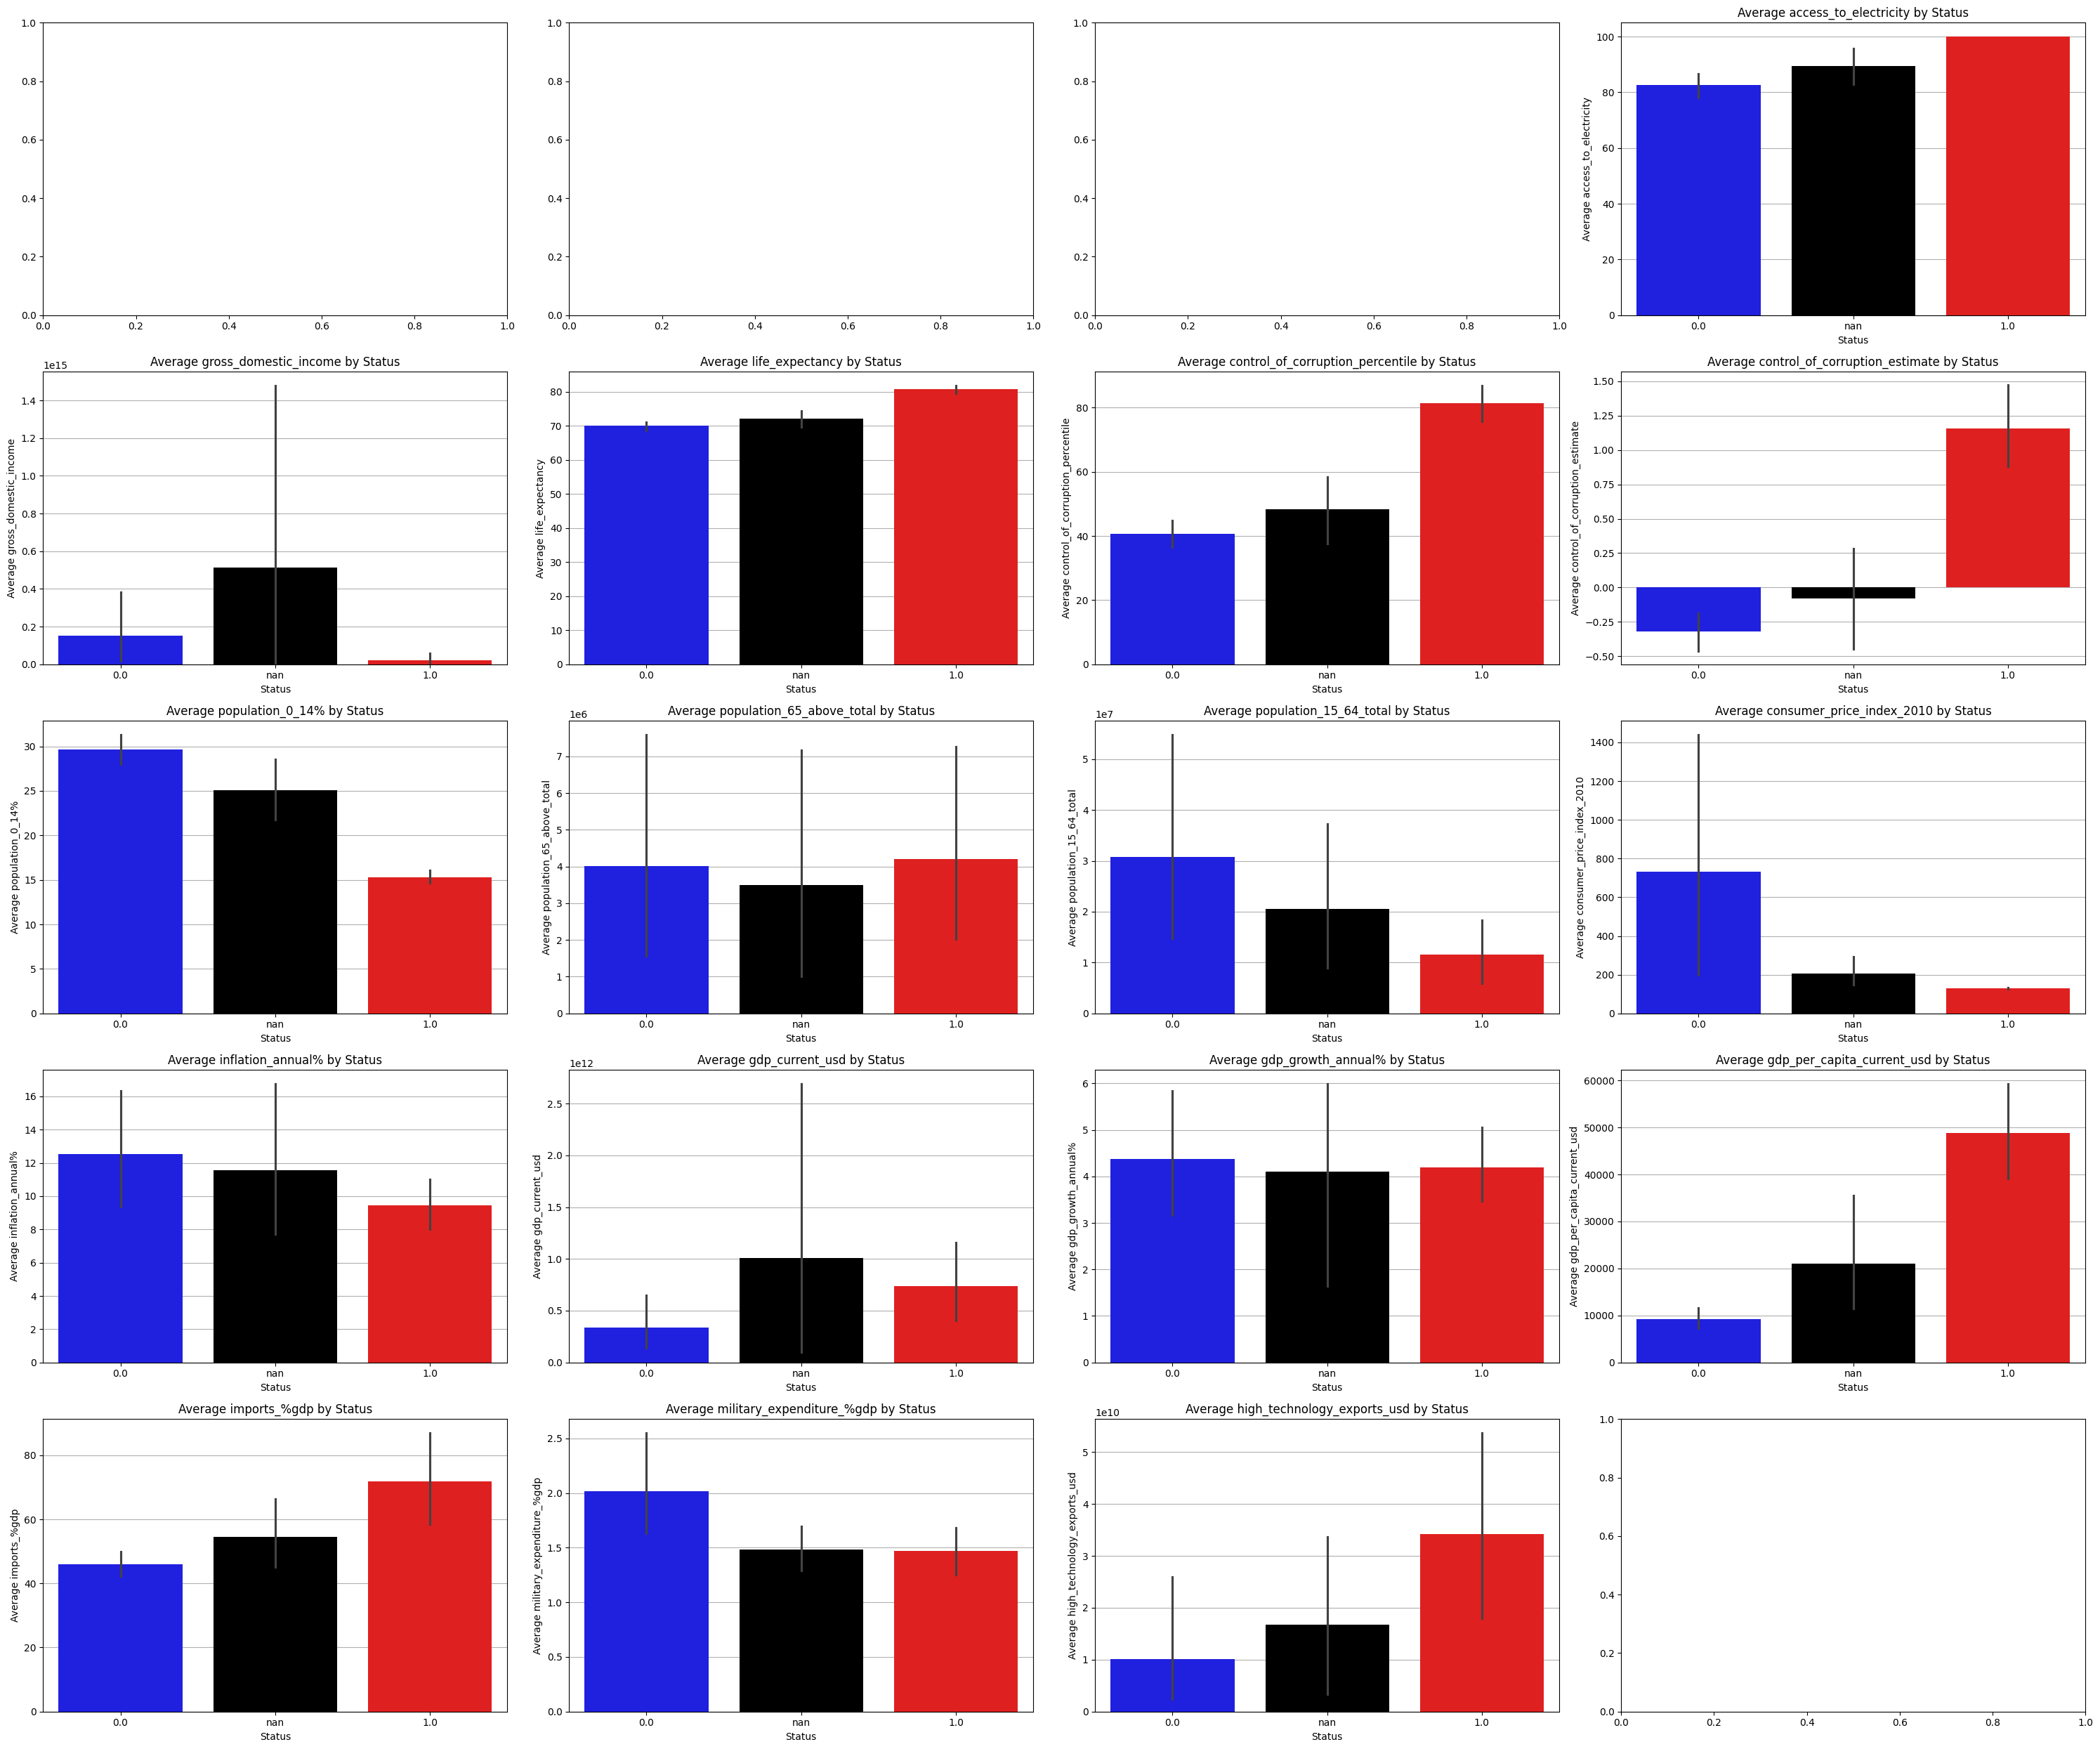

In [301]:
# Determine the number of rows and columns for subplots based on the number of columns
num_cols = len(feature_eng2.columns) - 2  # Exclude 'country_name' and 'country_code'
num_rows = (num_cols // 4) + 1  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, 4, figsize=(30, 25))  # Adjust figsize as needed

# Flatten axes array for easier iteration
axes = axes.flatten()

# Ensure 'status' column is treated as categorical and handle NaN values
feature_eng2['status'] = feature_eng2['status'].fillna('nan').astype(str)

# Define colors for each status category including NaN
palette = {'0.0': 'blue', '1.0': 'red', 'nan': 'black'}  # Adjust colors as needed

# Iterate through each column (excluding 'country_name' and 'country_code')
for i, col in enumerate(feature_eng2.columns):
    if col not in ['country_name', 'country_code', 'status']:
        # Check if there is data to plot
        if feature_eng2[col].notnull().any():  # Exclude empty plots
            sns.barplot(x='status', y=col, data=feature_eng2, ax=axes[i], estimator=np.mean, palette=palette)
            axes[i].set_title(f'Average {col} by Status')
            axes[i].set_xlabel('Status')
            axes[i].set_ylabel(f'Average {col}')
            axes[i].grid(axis='y')  # Show gridlines on y-axis
            axes[i].set_axisbelow(True)  # Ensure gridlines are behind bars

# Adjust layout
plt.tight_layout()
plt.show()

In [302]:
feature_eng2.isna().sum()

,0
country_name,0
country_code,0
status,0
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


## Upsampling Random to 50:50


In [303]:
feature_eng2['status'].value_counts()

,count
status,
0.0,134
nan,33
1.0,29


## Df Prep for ML

In [304]:
ml_df = feature_eng2.copy()
ct_status_pred = ml_df[ml_df['status'] == 'nan']
ct_status_pred.isna().sum()

,0
country_name,0
country_code,0
status,0
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [305]:
# Drop rows with missing values in the 'status' column
ml_df = ml_df.dropna(subset=['status'])

# Ensure the 'status' column is numeric and drop non-numeric values
ml_df['status'] = pd.to_numeric(ml_df['status'], errors='coerce')

# Create subsets
developed_country = ml_df[ml_df['status'] == 1]
developing_country = ml_df[ml_df['status'] == 0]

# Upsample developed_country to match the number of samples in developing_country
developed_country_upsampled = resample(developed_country,
                                       replace=True,
                                       n_samples=len(developing_country),
                                       random_state=42)


In [306]:
# Clease ml_df_upsampled
ml_df_upsampled = pd.concat([developing_country, developed_country_upsampled])
ml_df_upsampled['country_name'] = ml_df_upsampled['country_name'].str.replace('_',' ')

# Change country to match
value_to_chg = {'Russian Federation':'Russia','Viet Nam': 'Vietnam','Brunei Darussalam':'Brunei','Syrian Arab Republic':'Syria'}
ml_df_upsampled['country_name'] = ml_df_upsampled['country_name'].replace(value_to_chg)
ml_df_upsampled['status'].value_counts()
ml_df_upsampled

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,population_15_64_total,consumer_price_index_2010,inflation_annual%,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd
0,Afghanistan,AFG,0.0,85.3,1.010000e+12,62.88,12.26,-1.18,43.13,984763,22404909,156.81,7.95,1.450216e+10,-6.24,352.60,54.51,1.450,7.745430e+07
1,Albania,ALB,0.0,100.0,1.770000e+12,76.83,38.68,-0.41,16.15,462629,1866557,131.75,6.73,1.891638e+10,4.86,6810.11,47.75,1.580,8.864110e+05
2,Algeria,DZA,0.0,100.0,2.640000e+13,77.13,28.30,-0.64,30.64,2868322,28275097,181.62,9.27,2.260000e+11,3.60,5023.25,20.39,4.780,7.745430e+07
4,Angola,AGO,0.0,48.5,1.470000e+12,61.93,30.66,-0.60,45.02,925334,18643225,708.32,21.36,1.040000e+11,3.05,2933.48,25.30,1.330,7.720446e+07
5,Antigua and Barbuda,ATG,0.0,100.0,1.710000e+12,79.24,63.21,0.31,18.55,9956,66416,127.48,7.53,1.867733e+09,9.52,19919.73,62.94,1.450,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Ireland,IRL,1.0,100.0,4.290000e+11,83.06,93.87,1.67,19.58,776058,3346995,117.21,7.83,5.330000e+11,9.43,103983.29,97.18,0.230,8.000633e+10
48,Denmark,DNK,1.0,100.0,2.460000e+12,81.30,100.00,2.40,16.06,1209352,3745673,121.55,7.70,4.000000e+11,2.73,67790.05,58.92,1.420,1.432667e+10
144,Romania,ROU,1.0,100.0,5.960000e+11,75.30,55.66,0.02,15.92,3550764,12464175,151.87,13.80,2.990000e+11,4.11,15692.31,49.95,1.730,8.356834e+09
78,Iceland,ISL,1.0,100.0,2.970000e+12,82.17,91.51,1.57,18.49,58542,252843,150.09,8.31,2.870183e+10,8.88,75135.09,45.94,1.445,3.221220e+08


## T-test in every columns

In [307]:
## Exclude this columns to run the code
exclude_cols = ['country_name', 'country_code', 'status']


for col in ml_df_upsampled.columns:
    if col not in exclude_cols:

        ttest_deving = ml_df_upsampled[ml_df_upsampled['status'] == 0][col]
        ttest_deved = ml_df_upsampled[ml_df_upsampled['status'] == 1][col]
        # Perform the t-test
        t_stat, p_value = ttest_ind(ttest_deved, ttest_deving, nan_policy='omit')
        print(f"Feature: {col}")
        print(f"T-statistic: {t_stat}")
        print(f"P-value: {p_value}")
        # Interpret the results
        if p_value < 0.05:
            print(f"{col} is significantly different \n")
        else:
            print(f"{col} is not significantly different \n")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Feature: access_to_electricity
T-statistic: 7.739204327364961
P-value: 2.0887419907603317e-13
access_to_electricity is significantly different 

Feature: gross_domestic_income
T-statistic: -1.3809083486957046
P-value: 0.16846621860504646
gross_domestic_income is not significantly different 

Feature: life_expectancy
T-statistic: 16.04928607537462
P-value: 5.321413975502343e-41
life_expectancy is significantly different 

Feature: control_of_corruption_percentile
T-statistic: 16.29345388703869
P-value: 7.212283139379725e-42
control_of_corruption_percentile is significantly different 

Feature: control_of_corruption_estimate
T-statistic: 15.827084999275469
P-value: 3.2794577164782167e-40
control_of_corruption_estimate is significantly different 

Feature: population_0_14%
T-statistic: -16.579887151099893
P-value: 6.918213139010418e-43
population_0_14% is significantly different 

Feature: population_65_above_total
T-statistic: -0.22667139455334662
P-value: 0.8208533664694474
population_6

## Freedom_df LEFT JOIN ml_df_upsampled to be ml_df_upsampled2 and cleanse the dataframe

In [308]:
ml_df_upsampled2 = pd.merge(ml_df_upsampled, freedom_df, on='country_name', how='left')

In [309]:
ml_df_upsampled2.head(5)

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd,freedom_status,political_rights,civil_liberties,total_freedom_score
0,Afghanistan,AFG,0.0,85.3,1.010000e+12,62.88,12.26,-1.18,43.13,984763,...,1.450216e+10,-6.24,352.60,54.51,1.45,77454299.5,Not Free,1.0,5.0,6.0
1,Albania,ALB,0.0,100.0,1.770000e+12,76.83,38.68,-0.41,16.15,462629,...,1.891638e+10,4.86,6810.11,47.75,1.58,886411.0,Partly Free,28.0,40.0,68.0
2,Algeria,DZA,0.0,100.0,2.640000e+13,77.13,28.30,-0.64,30.64,2868322,...,2.260000e+11,3.60,5023.25,20.39,4.78,77454299.5,Not Free,10.0,22.0,32.0
3,Angola,AGO,0.0,48.5,1.470000e+12,61.93,30.66,-0.60,45.02,925334,...,1.040000e+11,3.05,2933.48,25.30,1.33,77204455.0,Not Free,10.0,18.0,28.0
4,Antigua and Barbuda,ATG,0.0,100.0,1.710000e+12,79.24,63.21,0.31,18.55,9956,...,1.867733e+09,9.52,19919.73,62.94,1.45,0.0,Free,33.0,52.0,85.0


In [310]:
ml_df_upsampled2.isna().sum()

,0
country_name,0
country_code,0
status,0
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [311]:
ml_df_upsampled2[ml_df_upsampled2['freedom_status'].isna()]

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd,freedom_status,political_rights,civil_liberties,total_freedom_score
102,Sao Tome and Principe,STP,0.0,78.0,1.710000e+12,68.79,62.74,0.28,39.47,8550,...,542686976.0,0.07,2386.7,42.18,1.45,15026.0,NaN,NaN,NaN,NaN


In [312]:
# Clease ml_df_upsampled2
for col in ['political_rights','civil_liberties']:
    if ml_df_upsampled2[col].isna().any():
        # Calculate the mean of the column where ml_df_status is 0
        mean_value = ml_df_upsampled2[ml_df_upsampled2['status'] == 0][col].mean()

        # Fill missing values with the calculated mean
        ml_df_upsampled2[col] = ml_df_upsampled2[col].fillna(mean_value)

# Fill missing value in the freedom_status using average of developing country to fill
freedom_score = ml_df_upsampled2['political_rights'] + ml_df_upsampled2['civil_liberties']
ml_df_upsampled2['total_freedom_score'] = ml_df_upsampled2['total_freedom_score'].fillna(freedom_score)



In [313]:
# Check missing value
print(ml_df_upsampled2.isna().sum())

country_name                        0
country_code                        0
status                              0
access_to_electricity               0
gross_domestic_income               0
life_expectancy                     0
control_of_corruption_percentile    0
control_of_corruption_estimate      0
population_0_14%                    0
population_65_above_total           0
population_15_64_total              0
consumer_price_index_2010           0
inflation_annual%                   0
gdp_current_usd                     0
gdp_growth_annual%                  0
gdp_per_capita_current_usd          0
imports_%gdp                        0
military_expenditure_%gdp           0
high_technology_exports_usd         0
freedom_status                      1
political_rights                    0
civil_liberties                     0
total_freedom_score                 0
dtype: int64


In [314]:
# Check missing value
print(ml_df_upsampled2[ml_df_upsampled2['freedom_status'].isna()]['total_freedom_score'])

102    50.398496
Name: total_freedom_score, dtype: float64


In [315]:
# Group by 'freedom_status' and calculate min and max of 'total_freedom_score'
freedom_score_stats = ml_df_upsampled2.groupby('freedom_status')['total_freedom_score'].agg(['min', 'max'])

# Display the results
print(freedom_score_stats.sort_values(by='min'))

# Fill missing value in the freedom_status column
ml_df_upsampled2['freedom_status'] = ml_df_upsampled2['freedom_status'].fillna('Partly Free')

                 min    max
freedom_status             
Not Free         1.0   34.0
Partly Free     33.0   69.0
Free            66.0  100.0


In [316]:
# Check dataset balance
ml_df_upsampled['status'].value_counts()

,count
status,
0.0,134
1.0,134


In [317]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'freedom_status' column
ml_df_upsampled2['freedom_status_encoded'] = label_encoder.fit_transform(ml_df_upsampled2['freedom_status'])

# Display the first few rows to check the encoding
print(ml_df_upsampled2[['freedom_status', 'freedom_status_encoded']].head())


  freedom_status  freedom_status_encoded
0       Not Free                       1
1    Partly Free                       2
2       Not Free                       1
3       Not Free                       1
4           Free                       0


In [318]:
# Drop the 'freedom_status' column
ml_df_upsampled2 = ml_df_upsampled2.drop(columns=['freedom_status'])

ml_df_upsampled2.head(5)

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd,political_rights,civil_liberties,total_freedom_score,freedom_status_encoded
0,Afghanistan,AFG,0.0,85.3,1.010000e+12,62.88,12.26,-1.18,43.13,984763,...,1.450216e+10,-6.24,352.60,54.51,1.45,77454299.5,1.0,5.0,6.0,1
1,Albania,ALB,0.0,100.0,1.770000e+12,76.83,38.68,-0.41,16.15,462629,...,1.891638e+10,4.86,6810.11,47.75,1.58,886411.0,28.0,40.0,68.0,2
2,Algeria,DZA,0.0,100.0,2.640000e+13,77.13,28.30,-0.64,30.64,2868322,...,2.260000e+11,3.60,5023.25,20.39,4.78,77454299.5,10.0,22.0,32.0,1
3,Angola,AGO,0.0,48.5,1.470000e+12,61.93,30.66,-0.60,45.02,925334,...,1.040000e+11,3.05,2933.48,25.30,1.33,77204455.0,10.0,18.0,28.0,1
4,Antigua and Barbuda,ATG,0.0,100.0,1.710000e+12,79.24,63.21,0.31,18.55,9956,...,1.867733e+09,9.52,19919.73,62.94,1.45,0.0,33.0,52.0,85.0,0


In [319]:
# Find the maximum value in the 'gdp_current_usd' column
max_value = ml_df_upsampled2['gdp_current_usd'].max()

# Select the rows where 'gdp_current_usd' is equal to the maximum value
rows_with_max_value = ml_df_upsampled2[ml_df_upsampled2['gdp_current_usd'] == max_value]
max_value

17900000000000.0

## Logistic Regression

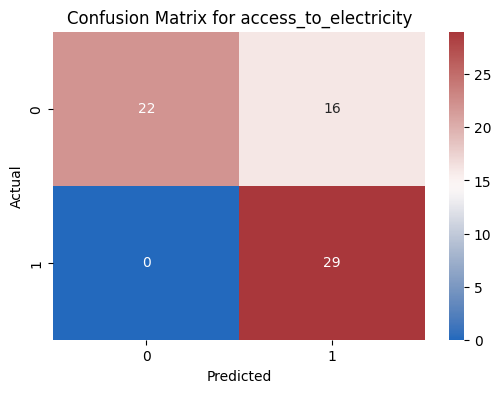

Feature: access_to_electricity
Accuracy: 0.7611940298507462
              precision    recall  f1-score   support

         0.0       1.00      0.58      0.73        38
         1.0       0.64      1.00      0.78        29

    accuracy                           0.76        67
   macro avg       0.82      0.79      0.76        67
weighted avg       0.85      0.76      0.76        67





/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

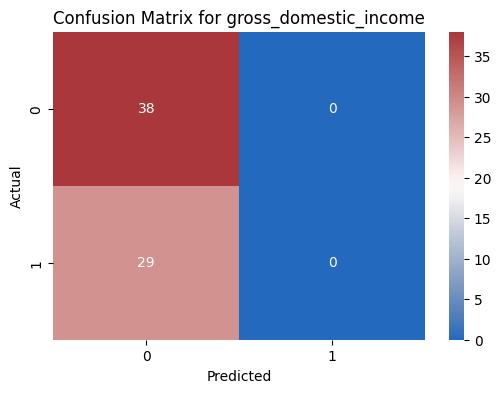

Feature: gross_domestic_income
Accuracy: 0.5671641791044776
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72        38
         1.0       0.00      0.00      0.00        29

    accuracy                           0.57        67
   macro avg       0.28      0.50      0.36        67
weighted avg       0.32      0.57      0.41        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


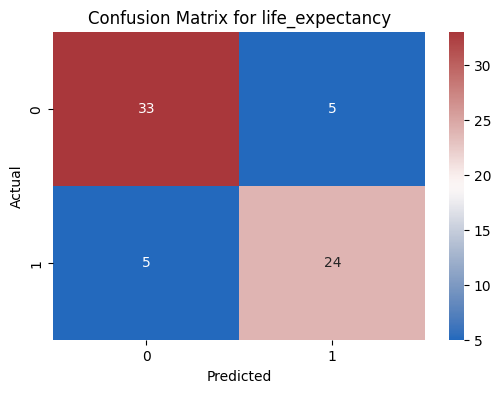

Feature: life_expectancy
Accuracy: 0.8507462686567164
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        38
         1.0       0.83      0.83      0.83        29

    accuracy                           0.85        67
   macro avg       0.85      0.85      0.85        67
weighted avg       0.85      0.85      0.85        67





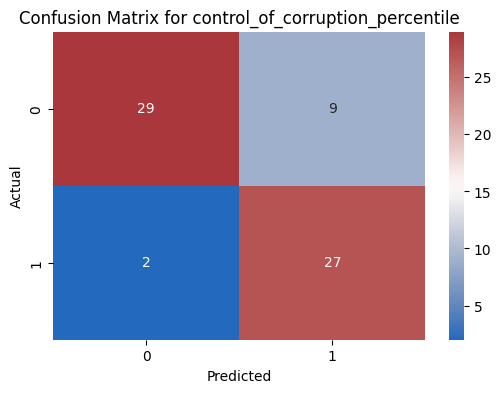

Feature: control_of_corruption_percentile
Accuracy: 0.835820895522388
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84        38
         1.0       0.75      0.93      0.83        29

    accuracy                           0.84        67
   macro avg       0.84      0.85      0.84        67
weighted avg       0.86      0.84      0.84        67





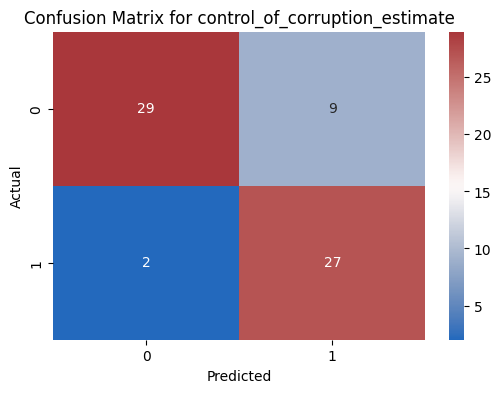

Feature: control_of_corruption_estimate
Accuracy: 0.835820895522388
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84        38
         1.0       0.75      0.93      0.83        29

    accuracy                           0.84        67
   macro avg       0.84      0.85      0.84        67
weighted avg       0.86      0.84      0.84        67





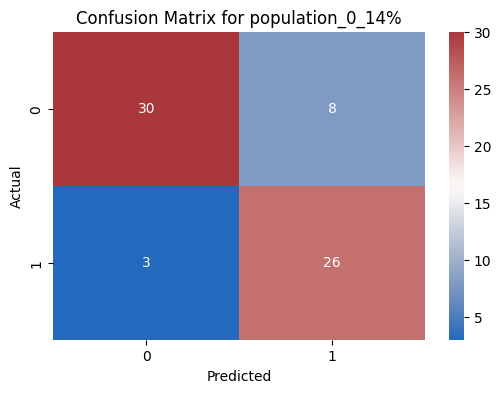

Feature: population_0_14%
Accuracy: 0.835820895522388
              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85        38
         1.0       0.76      0.90      0.83        29

    accuracy                           0.84        67
   macro avg       0.84      0.84      0.84        67
weighted avg       0.85      0.84      0.84        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


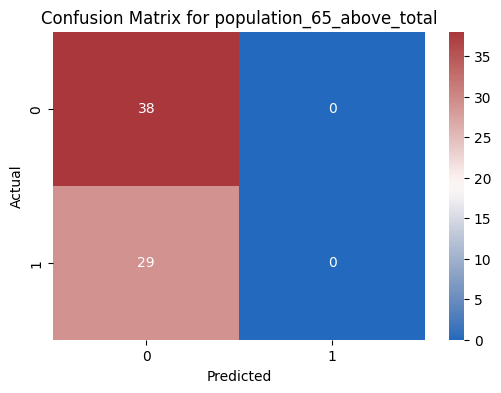

Feature: population_65_above_total
Accuracy: 0.5671641791044776
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72        38
         1.0       0.00      0.00      0.00        29

    accuracy                           0.57        67
   macro avg       0.28      0.50      0.36        67
weighted avg       0.32      0.57      0.41        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

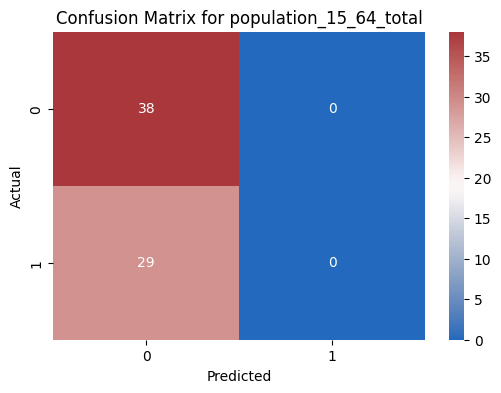

Feature: population_15_64_total
Accuracy: 0.5671641791044776
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72        38
         1.0       0.00      0.00      0.00        29

    accuracy                           0.57        67
   macro avg       0.28      0.50      0.36        67
weighted avg       0.32      0.57      0.41        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


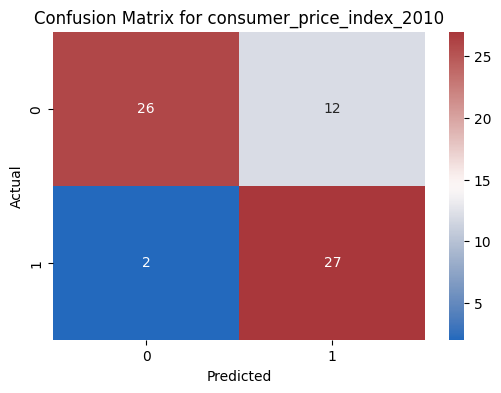

Feature: consumer_price_index_2010
Accuracy: 0.7910447761194029
              precision    recall  f1-score   support

         0.0       0.93      0.68      0.79        38
         1.0       0.69      0.93      0.79        29

    accuracy                           0.79        67
   macro avg       0.81      0.81      0.79        67
weighted avg       0.83      0.79      0.79        67





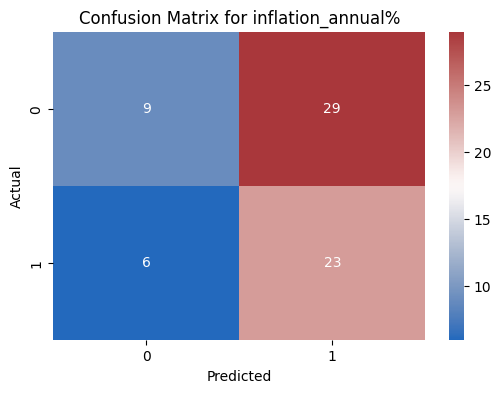

Feature: inflation_annual%
Accuracy: 0.47761194029850745
              precision    recall  f1-score   support

         0.0       0.60      0.24      0.34        38
         1.0       0.44      0.79      0.57        29

    accuracy                           0.48        67
   macro avg       0.52      0.51      0.45        67
weighted avg       0.53      0.48      0.44        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


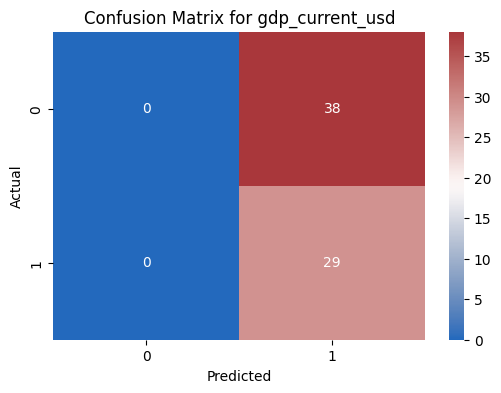

Feature: gdp_current_usd
Accuracy: 0.43283582089552236
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        38
         1.0       0.43      1.00      0.60        29

    accuracy                           0.43        67
   macro avg       0.22      0.50      0.30        67
weighted avg       0.19      0.43      0.26        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


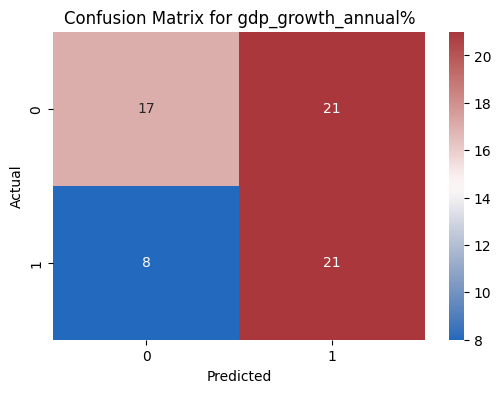

Feature: gdp_growth_annual%
Accuracy: 0.5671641791044776
              precision    recall  f1-score   support

         0.0       0.68      0.45      0.54        38
         1.0       0.50      0.72      0.59        29

    accuracy                           0.57        67
   macro avg       0.59      0.59      0.57        67
weighted avg       0.60      0.57      0.56        67





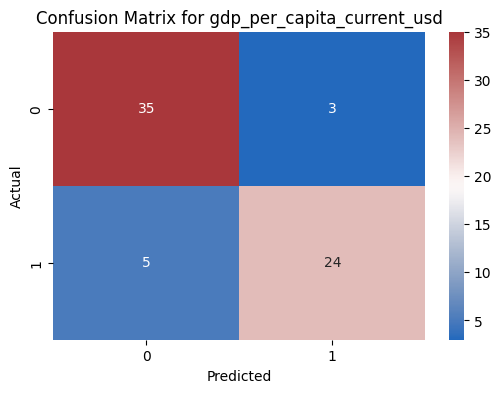

Feature: gdp_per_capita_current_usd
Accuracy: 0.8805970149253731
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        38
         1.0       0.89      0.83      0.86        29

    accuracy                           0.88        67
   macro avg       0.88      0.87      0.88        67
weighted avg       0.88      0.88      0.88        67





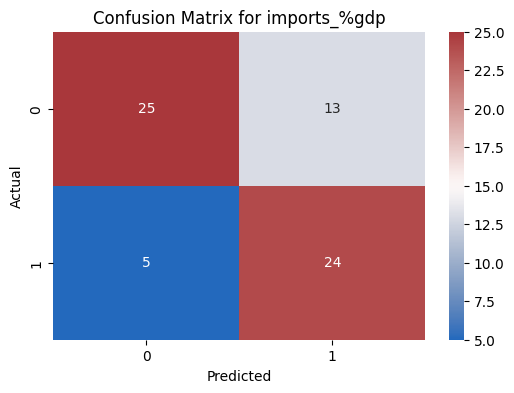

Feature: imports_%gdp
Accuracy: 0.7313432835820896
              precision    recall  f1-score   support

         0.0       0.83      0.66      0.74        38
         1.0       0.65      0.83      0.73        29

    accuracy                           0.73        67
   macro avg       0.74      0.74      0.73        67
weighted avg       0.75      0.73      0.73        67





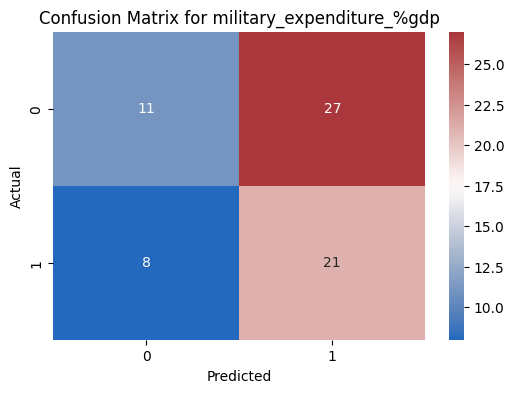

Feature: military_expenditure_%gdp
Accuracy: 0.47761194029850745
              precision    recall  f1-score   support

         0.0       0.58      0.29      0.39        38
         1.0       0.44      0.72      0.55        29

    accuracy                           0.48        67
   macro avg       0.51      0.51      0.47        67
weighted avg       0.52      0.48      0.45        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


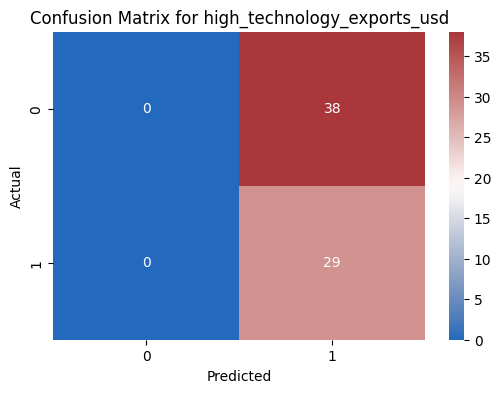

Feature: high_technology_exports_usd
Accuracy: 0.43283582089552236
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        38
         1.0       0.43      1.00      0.60        29

    accuracy                           0.43        67
   macro avg       0.22      0.50      0.30        67
weighted avg       0.19      0.43      0.26        67





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


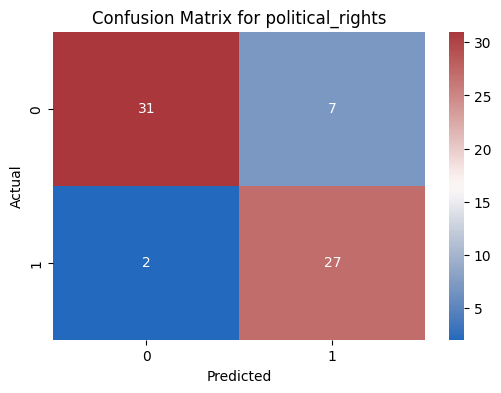

Feature: political_rights
Accuracy: 0.8656716417910447
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.87        38
         1.0       0.79      0.93      0.86        29

    accuracy                           0.87        67
   macro avg       0.87      0.87      0.87        67
weighted avg       0.88      0.87      0.87        67





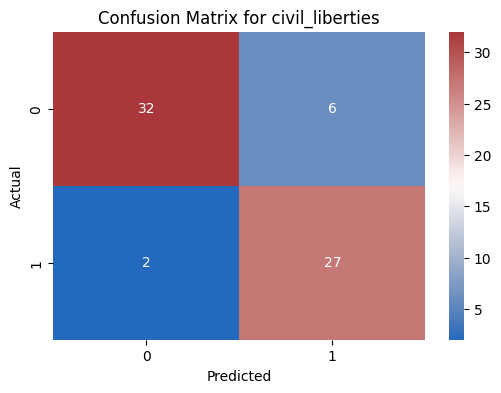

Feature: civil_liberties
Accuracy: 0.8805970149253731
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89        38
         1.0       0.82      0.93      0.87        29

    accuracy                           0.88        67
   macro avg       0.88      0.89      0.88        67
weighted avg       0.89      0.88      0.88        67





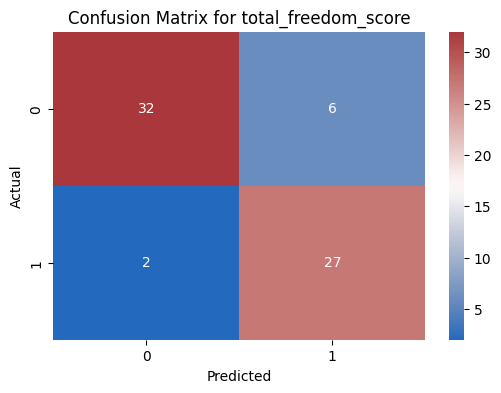

Feature: total_freedom_score
Accuracy: 0.8805970149253731
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89        38
         1.0       0.82      0.93      0.87        29

    accuracy                           0.88        67
   macro avg       0.88      0.89      0.88        67
weighted avg       0.89      0.88      0.88        67





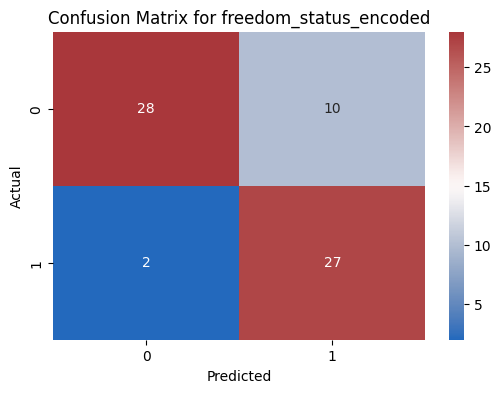

Feature: freedom_status_encoded
Accuracy: 0.8208955223880597
              precision    recall  f1-score   support

         0.0       0.93      0.74      0.82        38
         1.0       0.73      0.93      0.82        29

    accuracy                           0.82        67
   macro avg       0.83      0.83      0.82        67
weighted avg       0.85      0.82      0.82        67





In [320]:
# Features to exclude from analysis
exclude_cols = ['country_name', 'country_code', 'status']

results = {}
confusion_matrices = {}


# Iterate through each feature
for col in ml_df_upsampled2.columns:
    if col not in exclude_cols:
        X = ml_df_upsampled2[[col]]
        y = ml_df_upsampled2['status']

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Concatenate our training data back together
        train_data = pd.concat([X_train, y_train], axis=1)

        # Separate majority and minority classes
        majority = train_data[train_data['status'] == train_data['status'].mode()[0]]
        minority = train_data[train_data['status'] != train_data['status'].mode()[0]]

        # Upsample minority class
        minority_upsampled = resample(minority,
                                      replace=True,  # sample with replacement
                                      n_samples=len(majority),  # to match majority class
                                      random_state=42)  # reproducible results

        # Combine majority and upsampled minority
        upsampled = pd.concat([majority, minority_upsampled])

        # Split features and target variable from the upsampled data
        X_train_resampled = upsampled[[col]]
        y_train_resampled = upsampled['status']

        # Initialize and train the logistic regression model
        model = LogisticRegression()
        model.fit(X_train_resampled, y_train_resampled)

        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[col] = {
            'accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm
        }

        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='vlag', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.title(f'Confusion Matrix for {col}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        print(f"Feature: {col}")
        print(f"Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        print("\n" + "="*50 + "\n")


In [321]:
## Exclude this columns to run the code
exclude_cols = ['country_name', 'country_code', 'status']


for col in ml_df_upsampled.columns:
    if col not in exclude_cols:

        ttest_deving = ml_df_upsampled[ml_df_upsampled['status'] == 0][col]
        ttest_deved = ml_df_upsampled[ml_df_upsampled['status'] == 1][col]
        # Perform the t-test
        t_stat, p_value = ttest_ind(ttest_deved, ttest_deving, nan_policy='omit')
           # Interpret the results
        if p_value < 0.05:
            print([col])

['access_to_electricity']
['life_expectancy']
['control_of_corruption_percentile']
['control_of_corruption_estimate']
['population_0_14%']
['population_15_64_total']
['gdp_current_usd']
['gdp_per_capita_current_usd']
['imports_%gdp']
['military_expenditure_%gdp']
['high_technology_exports_usd']


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [322]:
# Cleanse Data create new dataframed named encoded_df
# Significantly different
features_1 = ['access_to_electricity', 'life_expectancy', 'control_of_corruption_percentile', 'control_of_corruption_estimate', 'population_0_14%', 'population_15_64_total', 'gdp_current_usd', 'gdp_per_capita_current_usd', 'imports_%gdp', 'military_expenditure_%gdp', 'high_technology_exports_usd','total_freedom_score',
       'freedom_status_encoded']

encoded_df = ml_df_upsampled2[['status'] + features_1]
columns_to_drop = ['control_of_corruption_percentile','population_15_64_total']

encoded_df = encoded_df.drop(columns=columns_to_drop)

encoded_df['access_to_elec'] = encoded_df['access_to_electricity'].apply(lambda x: 1 if x == 100 else 0)
encoded_df.drop(columns='access_to_electricity')
encoded_df['control_of_corruption_estimate'] = encoded_df['control_of_corruption_estimate'].apply(lambda x: 1 if x > -0.16 else 0)
encoded_df.drop(columns='control_of_corruption_estimate')
scaler = StandardScaler()

# Apply StandardScaler to gpd
encoded_df['gdp_current_usd'] = scaler.fit_transform(encoded_df[['gdp_current_usd']])

encoded_df = encoded_df.drop(columns=['military_expenditure_%gdp'])

In [323]:
encoded_df.columns

Index(['status', 'access_to_electricity', 'life_expectancy',
       'control_of_corruption_estimate', 'population_0_14%', 'gdp_current_usd',
       'gdp_per_capita_current_usd', 'imports_%gdp',
       'high_technology_exports_usd', 'total_freedom_score',
       'freedom_status_encoded', 'access_to_elec'],
      dtype='object')

## Bootstrap encode_df

In [324]:
import pandas as pd
from sklearn.utils import resample

# Assuming encode_df is already loaded as a DataFrame
# encode_df = pd.read_csv('path_to_csv')  # Uncomment if loading from a CSV

# Separate the dataset based on the 'status' column
class_0 = encoded_df[encoded_df['status'] == 0]
class_1 = encoded_df[encoded_df['status'] == 1]

# Determine the target size for upsampling
target_size = 1000

# List to hold the bootstrapped samples
bootstrap_samples = {}

# Number of bootstrap samples
n_samples = 20

for i in range(1, n_samples + 1):
    # Resample each class with replacement to the target size
    resampled_class_0 = resample(class_0, replace=True, n_samples=target_size // 2, random_state=i)
    resampled_class_1 = resample(class_1, replace=True, n_samples=target_size // 2, random_state=i)

    # Combine the resampled classes
    resampled_df = pd.concat([resampled_class_0, resampled_class_1], ignore_index=True)

    # Store the resampled DataFrame in a dictionary with dynamic naming
    bootstrap_samples[f'resampled_df{i}'] = resampled_df

# Output basic information about one of the bootstrapped datasets
print(f"Example bootstrapped DataFrame shape: {bootstrap_samples['resampled_df1'].shape}")


Example bootstrapped DataFrame shape: (1000, 12)


In [325]:
bootstrap_samples

{'resampled_df1':      status  access_to_electricity  life_expectancy  \
 0       0.0                  100.0            71.47   
 1       0.0                  100.0            76.26   
 2       0.0                   50.1            59.39   
 3       0.0                  100.0            76.19   
 4       0.0                  100.0            71.67   
 ..      ...                    ...              ...   
 995     1.0                  100.0            81.28   
 996     1.0                  100.0            75.30   
 997     1.0                  100.0            75.30   
 998     1.0                  100.0            83.20   
 999     1.0                  100.0            82.56   
 
      control_of_corruption_estimate  population_0_14%  gdp_current_usd  \
 0                                 0             25.42        -0.355307   
 1                                 1             22.67        -0.075524   
 2                                 0             40.63        -0.358755   
 3       

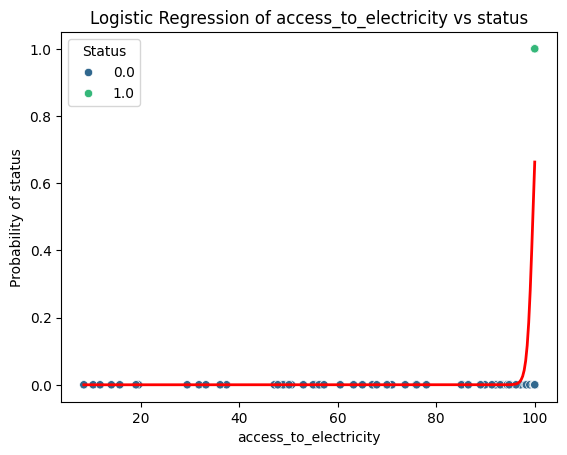

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


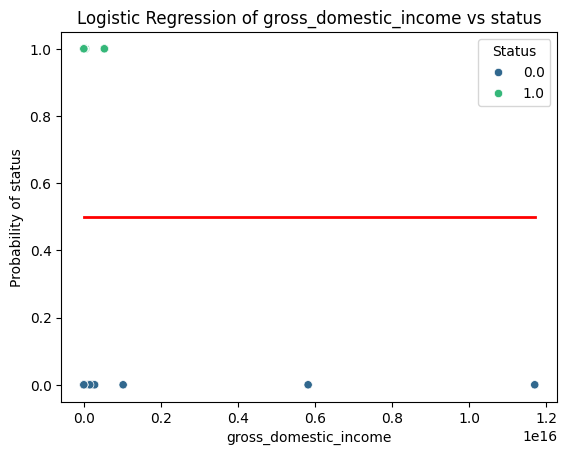

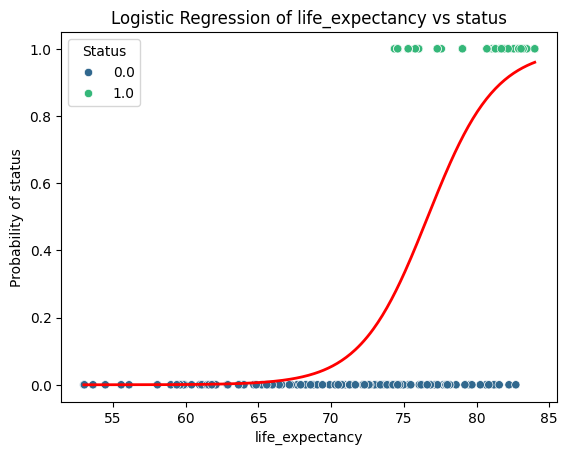

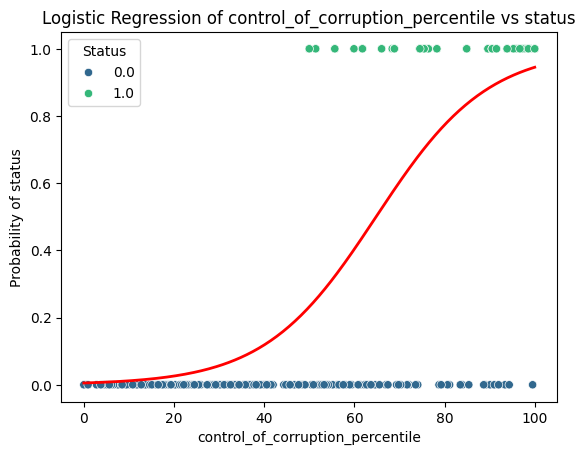

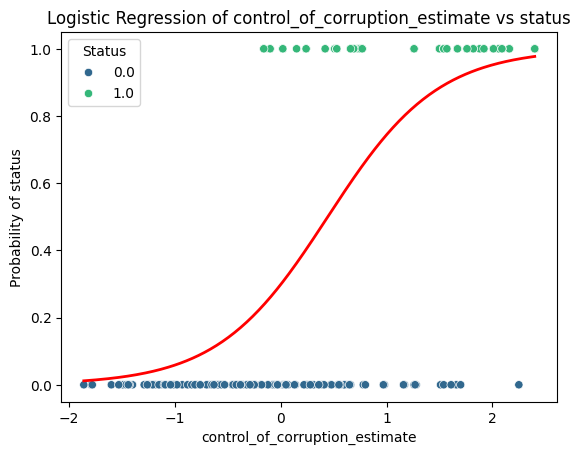

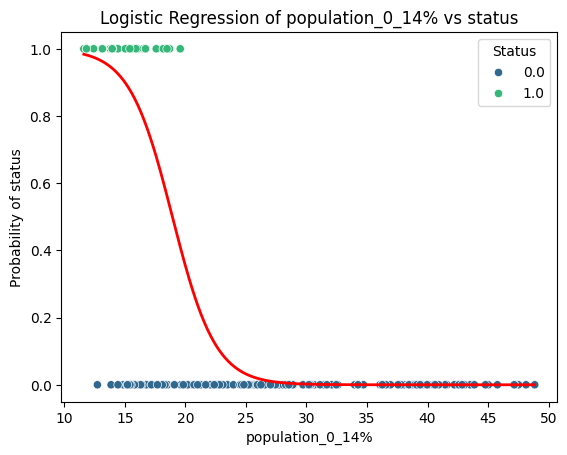

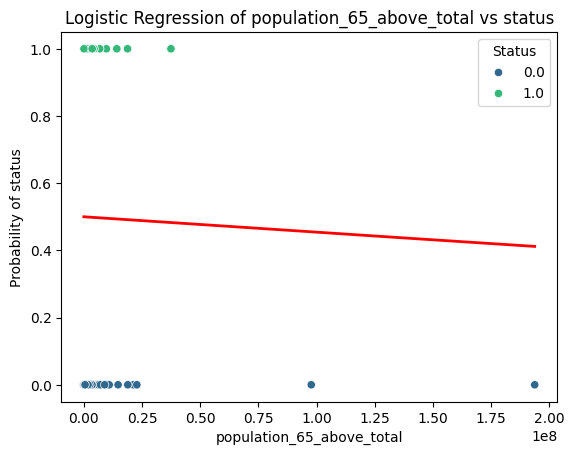

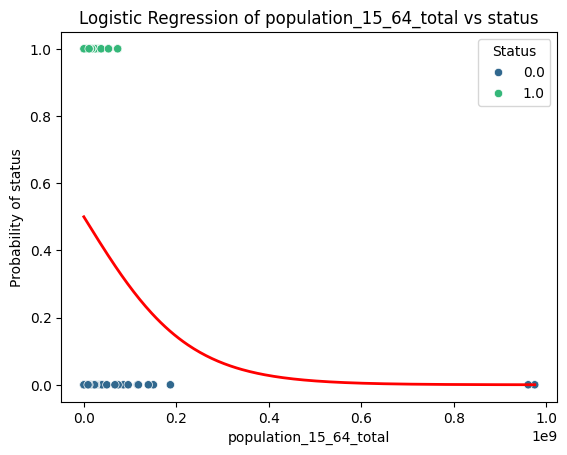

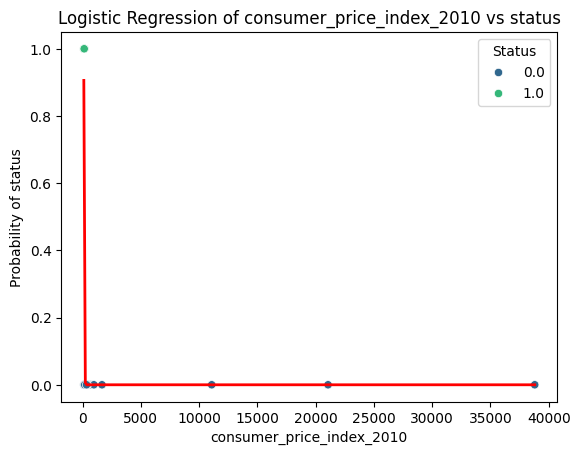

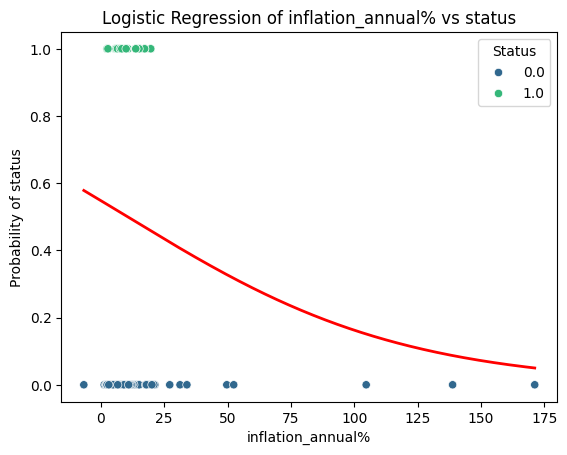

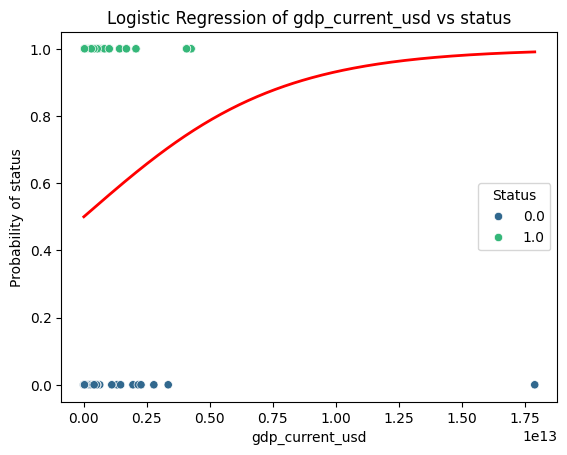

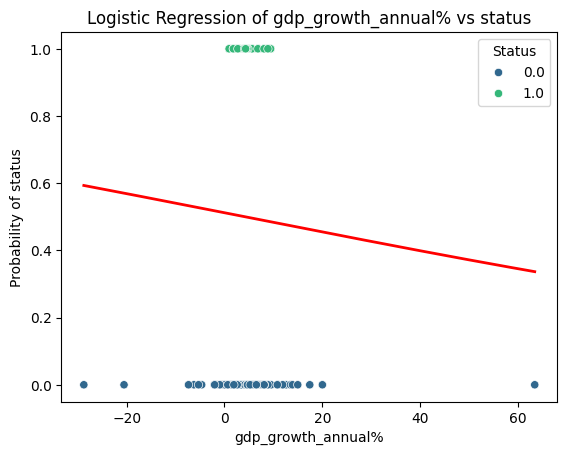

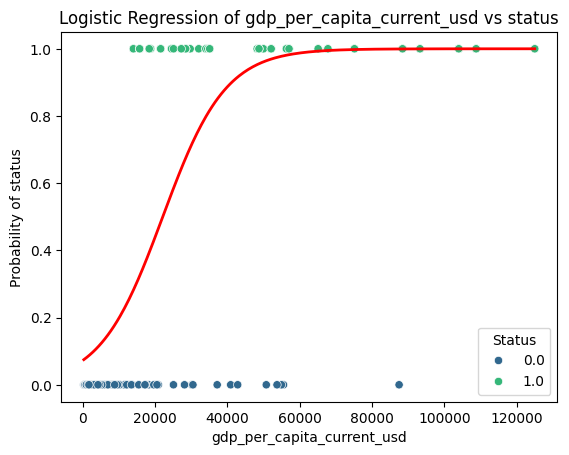

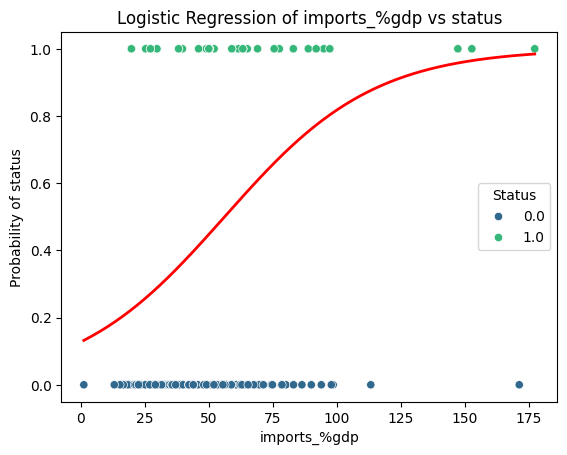

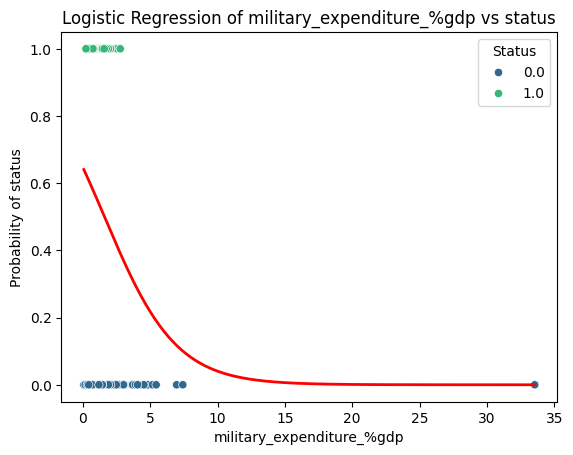

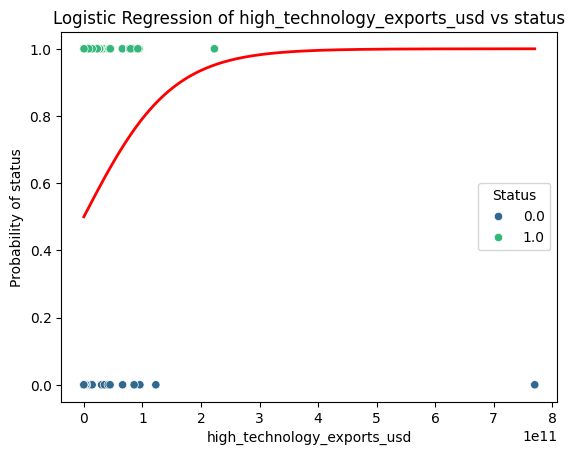

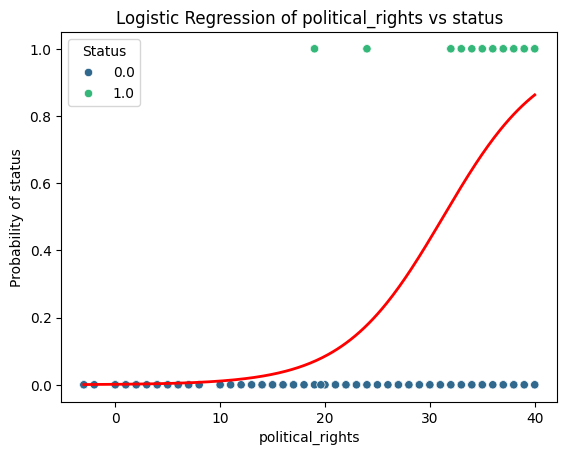

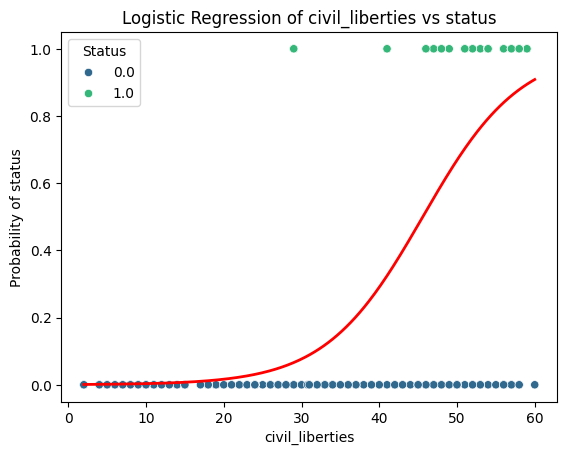

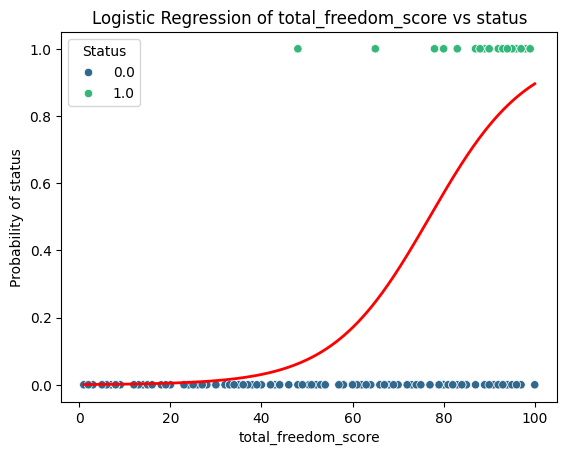

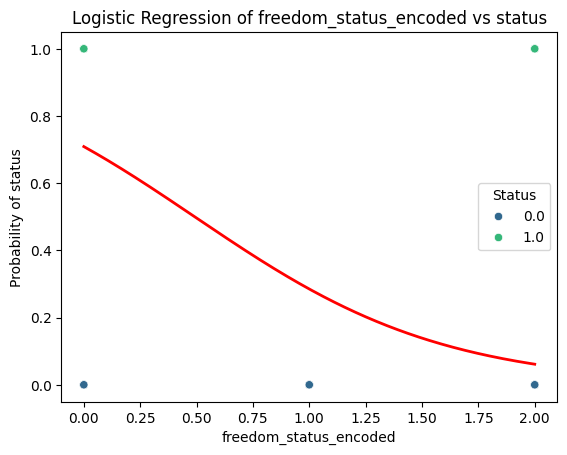

In [326]:
# List of columns to exclude from the plotting
exclude_cols = ['status', 'country_name', 'country_code']

# Create a logistic regression model instance
log_reg = LogisticRegression()

# Iterate over each column in ml_df_upsampled2 except the excluded ones
for col in ml_df_upsampled2.columns:
    if col not in exclude_cols:
        # Check if the column data type is numeric
        if ml_df_upsampled2[col].dtype in ['int64', 'float64']:
            X_column = col  # Current feature column
            y_column = 'status'  # Target column

            # Prepare the data
            X = ml_df_upsampled2[[X_column]].values
            y = ml_df_upsampled2[y_column].values

            # Fit the logistic regression model
            log_reg.fit(X, y)

            # Predict probabilities
            X_test = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
            y_prob = log_reg.predict_proba(X_test)[:, 1]

            # Plot the logistic regression line
            sns.scatterplot(x=X.squeeze(), y=y, hue=ml_df_upsampled2[y_column], palette='viridis')
            plt.plot(X_test, y_prob, color='red', linewidth=2)

            # Customize the plot
            plt.title(f'Logistic Regression of {X_column} vs {y_column}')
            plt.xlabel(X_column)
            plt.ylabel(f'Probability of {y_column}')
            plt.legend(title='Status')

            # Show the plot
            plt.show()


Decision Tree Accuracy: 0.9552238805970149
Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        38
         1.0       0.91      1.00      0.95        29

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



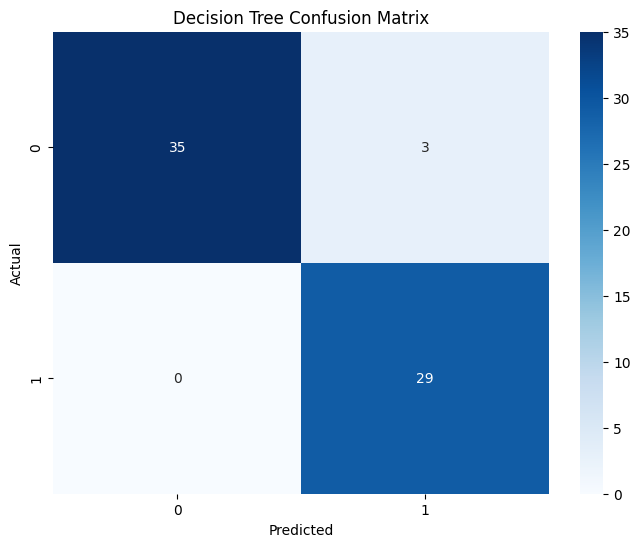

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Accuracy: 0.9701492537313433
AdaBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        38
         1.0       0.94      1.00      0.97        29

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67



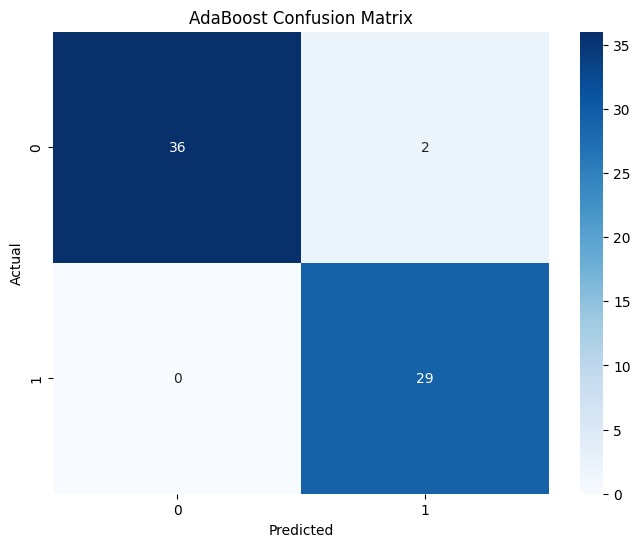

Random Forest Accuracy: 0.9850746268656716
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99        38
         1.0       0.97      1.00      0.98        29

    accuracy                           0.99        67
   macro avg       0.98      0.99      0.98        67
weighted avg       0.99      0.99      0.99        67



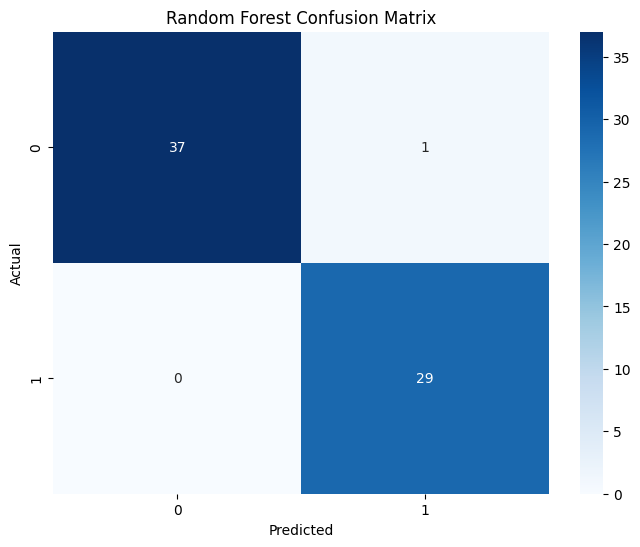

In [327]:
ml_df_test = ml_df_upsampled2.drop(columns=['country_code', 'country_name'])

# Features and target
X = encoded_df.drop(columns='status')
y = encoded_df['status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Decision Tree Model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Classification Report:")
print(report_dt)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AdaBoost Model
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
adaboost_model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
report_adaboost = classification_report(y_test, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_test, y_pred_adaboost)

print(f"AdaBoost Accuracy: {accuracy_adaboost}")
print("AdaBoost Classification Report:")
print(report_adaboost)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_adaboost, annot=True, fmt='d', cmap='Blues')
plt.title('AdaBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_rf = random_forest_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf}")
print("Random Forest Classification Report:")
print(report_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Gradient Boosting Accuracy: 0.9552238805970149
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96        38
         1.0       0.91      1.00      0.95        29

    accuracy                           0.96        67
   macro avg       0.95      0.96      0.95        67
weighted avg       0.96      0.96      0.96        67



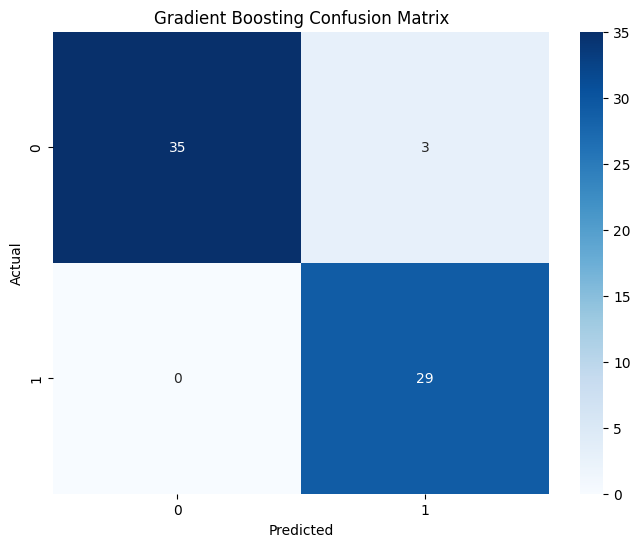

XGBoost Accuracy: 0.9701492537313433
XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        38
         1.0       0.94      1.00      0.97        29

    accuracy                           0.97        67
   macro avg       0.97      0.97      0.97        67
weighted avg       0.97      0.97      0.97        67



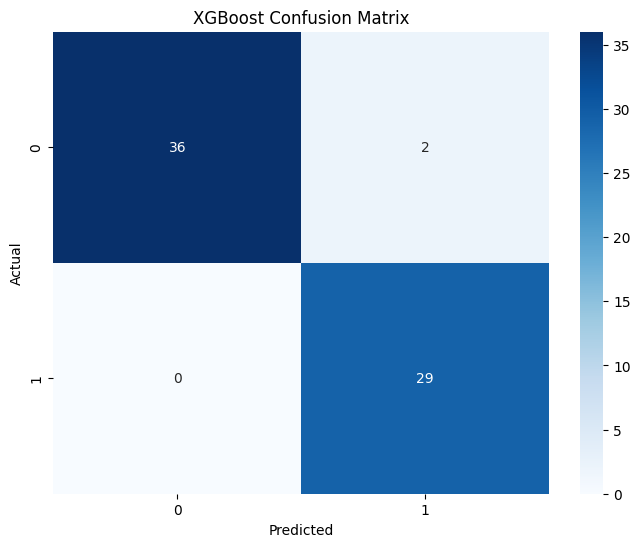

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes Accuracy: 0.43283582089552236
Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        38
         1.0       0.43      1.00      0.60        29

    accuracy                           0.43        67
   macro avg       0.22      0.50      0.30        67
weighted avg       0.19      0.43      0.26        67



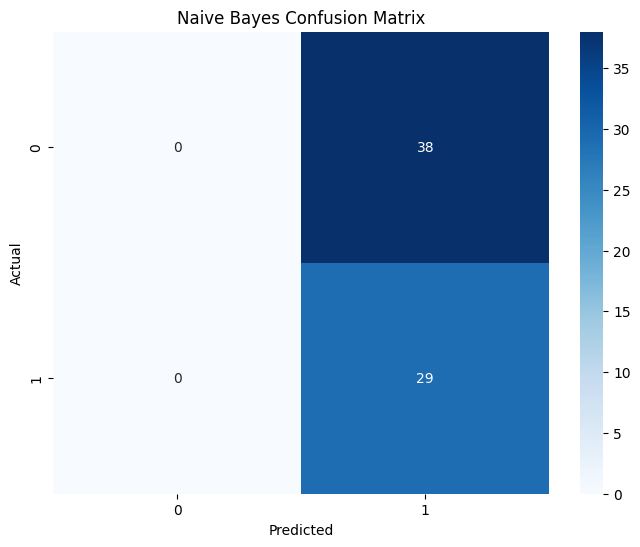

In [328]:
# Gradient Boosting Model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
report_gbm = classification_report(y_test, y_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)

print(f"Gradient Boosting Accuracy: {accuracy_gbm}")
print("Gradient Boosting Classification Report:")
print(report_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='d', cmap='Blues')
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# XGBoost Model
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb}")
print("XGBoost Classification Report:")
print(report_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Naive Bayes Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print(f"Naive Bayes Accuracy: {accuracy_nb}")
print("Naive Bayes Classification Report:")
print(report_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Country Status prediction

In [329]:
ct_status_pred = feature_eng2.copy()
ct_status_pred = ct_status_pred[ct_status_pred['status'] == 'nan']
ct_status_pred.rename(columns={'access_to_electricity': 'access_to_elec'}, inplace=True)
encoded_df.rename(columns={'access_to_electricity': 'access_to_elec'}, inplace=True)

In [330]:
ct_status_pred['country_name'] = ct_status_pred['country_name'].str.replace('_', ' ')

value_replacements = {'Aruba':'Aruba', # unable to find
 'Bahamas, The':'The Bahamas',
 'Congo, Dem. Rep.':'Democratic Republic of the Congo',
 'Congo, Rep.':'Republic of the Congo',
 "Cote d'Ivoire":"Côte d'Ivoire",
 'Curacao':'Curacao', # unable to find
 'Egypt, Arab Rep.':'Egypt',
 'Gambia, The':'The Gambia',
 'Hong Kong SAR, China':'Hong Kong',
 'Iran, Islamic Rep.':'Iran',
 "Korea, Dem. People's Rep.":'North Korea',
 'Korea, Rep.':'South Korea',
 'Kyrgyz Republic':'Kyrgyzstan',
 'Lao PDR':'Laos',
 'Macao SAR, China':'Macao SAR, China',# unable to find
 'Micronesia, Fed. Sts.':'Micronesia',
 'Slovak Republic':'Slovakia',
 'Turkiye':'Turkey',
 'Venezuela, RB':'Venezuela',
 'Yemen, Rep.':'Yemen'}

ct_status_pred['country_name'] = ct_status_pred['country_name'].replace(value_replacements)

In [331]:
status_pred = pd.merge(ct_status_pred, freedom_df, on='country_name', how='left')

In [332]:
status_pred[['political_rights', 'civil_liberties', 'total_freedom_score']] = status_pred[['political_rights', 'civil_liberties', 'total_freedom_score']].fillna(status_pred[['political_rights', 'civil_liberties', 'total_freedom_score']].mean())
status_pred[['freedom_status']] = status_pred[['freedom_status']].fillna('Partly Free')


In [333]:
# Create the drop_list by identifying columns present in status_pred but not in encoded_df
drop_list = list(set(status_pred.columns) - set(encoded_df.columns))

# Specify the columns you want to exclude from dropping
columns_to_exclude = ['country_name', 'country_code']

# Filter out the columns you want to exclude from the drop_list
drop_list = [col for col in drop_list if col not in columns_to_exclude]

# Drop the columns from status_pred
status_pred = status_pred.drop(columns=drop_list)

In [334]:
status_pred['freedom_status_encoded'] = status_pred['total_freedom_score'].apply(lambda x: 1 if x <= 33 else (2 if x <= 66 else (0 if x <= 100 else None)))
status_pred['encoded_access_to_elec'] = status_pred['access_to_elec'].apply(lambda x: 0 if x < 100 else 1 )
encoded_df.rename(columns={encoded_df.columns[-1]:"encoded_access_to_elec"},inplace=True)
encoded_df.rename(columns={encoded_df.columns[1]:"access_to_elec"},inplace=True)
status_pred['control_of_corruption_estimate'] = status_pred['control_of_corruption_estimate'].apply(lambda x: 1 if x > -0.16 else 0)
encoded_df = encoded_df.drop(columns=encoded_df.columns[-2])




In [335]:
# Define the maximum value you want to map back to
max_original_value = 17900000000000.0

# Define the minimum value of the original data (adjust if known)
min_original_value = 0 # Example, replace with actual min_value if known

# Apply the inverse scaling formula
encoded_df['gdp_current_usd'] = ((encoded_df['gdp_current_usd'] + 1) *
                                        (max_original_value - min_original_value) / 2 +
                                        min_original_value)

In [336]:
# Update data types in `encoded_df` to match `status_pred`
encoded_df['status'] = encoded_df['status'].astype('object')
encoded_df['access_to_elec'] = encoded_df['access_to_elec'].astype('float64')

# Check if `encoded_access_to_elec` exists in `status_pred` and is not in `encoded_df`
if 'encoded_access_to_elec' in status_pred.columns:
    encoded_df['encoded_access_to_elec'] = pd.Series([0] * len(encoded_df)).astype('int64')  # Add the column with default values

# Display the updated DataFrames' data types
print("encoded_df dtypes:")
print(encoded_df.dtypes)

print("\nstatus_pred dtypes:")
print(status_pred.dtypes)

encoded_df dtypes:
status                             object
access_to_elec                    float64
life_expectancy                   float64
control_of_corruption_estimate      int64
population_0_14%                  float64
gdp_current_usd                   float64
gdp_per_capita_current_usd        float64
imports_%gdp                      float64
high_technology_exports_usd       float64
total_freedom_score               float64
access_to_elec                    float64
encoded_access_to_elec              int64
dtype: object

status_pred dtypes:
country_name                       object
country_code                       object
status                             object
access_to_elec                    float64
life_expectancy                   float64
control_of_corruption_estimate      int64
population_0_14%                  float64
gdp_current_usd                   float64
gdp_per_capita_current_usd        float64
imports_%gdp                      float64
high_technology_export

In [337]:
status_pred.iloc[:,2:].head(3)

,status,access_to_elec,life_expectancy,control_of_corruption_estimate,population_0_14%,gdp_current_usd,gdp_per_capita_current_usd,imports_%gdp,high_technology_exports_usd,total_freedom_score,freedom_status_encoded,encoded_access_to_elec
0,nan,100.0,73.045,1,12.80,3.380602e+09,42350.70,47.81,43398343.0,93.000000,0,1
1,nan,99.9,74.990,1,16.24,3.544708e+09,33300.84,77.33,1735161.0,53.233333,2,0
2,nan,100.0,74.360,1,19.06,1.313640e+10,32041.25,43.75,0.0,91.000000,0,1


In [338]:
# Remove duplicate columns from encoded_df
encoded_df_cleaned = encoded_df.loc[:, ~encoded_df.columns.duplicated()]

# Now, concatenate the cleaned DataFrame with status_pred
df_union_all = pd.concat([encoded_df_cleaned, status_pred.iloc[:, 2:]], ignore_index=True)

# Display the result
df_union_all.shape


(301, 12)

In [339]:
df_union_all.head(3)

,status,access_to_elec,life_expectancy,control_of_corruption_estimate,population_0_14%,gdp_current_usd,gdp_per_capita_current_usd,imports_%gdp,high_technology_exports_usd,total_freedom_score,encoded_access_to_elec,freedom_status_encoded
0,0.0,85.3,62.88,0,43.13,5.653240e+12,352.60,54.51,77454299.5,6.0,0,NaN
1,0.0,100.0,76.83,0,16.15,5.682715e+12,6810.11,47.75,886411.0,68.0,0,NaN
2,0.0,100.0,77.13,0,30.64,7.065471e+12,5023.25,20.39,77454299.5,32.0,0,NaN


In [340]:
x = df_union_all['total_freedom_score']
# Apply the lambda function to fill missing values in 'freedom_status_encoded'
df_union_all['freedom_status_encoded'] = df_union_all['freedom_status_encoded'].fillna(
    x.apply(lambda val: 1 if val <= 33 else (2 if val <= 66 else (0 if val <= 100 else None)))
)
df_union_all['status'] = df_union_all['status'].replace("nan",np.nan)

In [341]:
df_union_all['status'].value_counts(dropna=False)

,count
status,
0.0,134
1.0,134
NaN,33


In [342]:
df_union_all.isna().sum()

,0
status,33
access_to_elec,0
life_expectancy,0
control_of_corruption_estimate,0
population_0_14%,0
gdp_current_usd,0
gdp_per_capita_current_usd,0
imports_%gdp,0
high_technology_exports_usd,0
total_freedom_score,0


<ipython-input-343-f2f10d3afadf>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_info['status'] = y_pred


                       country_name country_code  status
0                           Andorra          AND     0.0
1                             Aruba          ABW     0.0
2                       The Bahamas          BHS     0.0
3                           Bolivia          BOL     0.0
4  Democratic Republic of the Congo          COD     0.0
Accuracy on known data: 1.0
Classification Report on known data:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       134
         1.0       1.00      1.00      1.00       134

    accuracy                           1.00       268
   macro avg       1.00      1.00      1.00       268
weighted avg       1.00      1.00      1.00       268



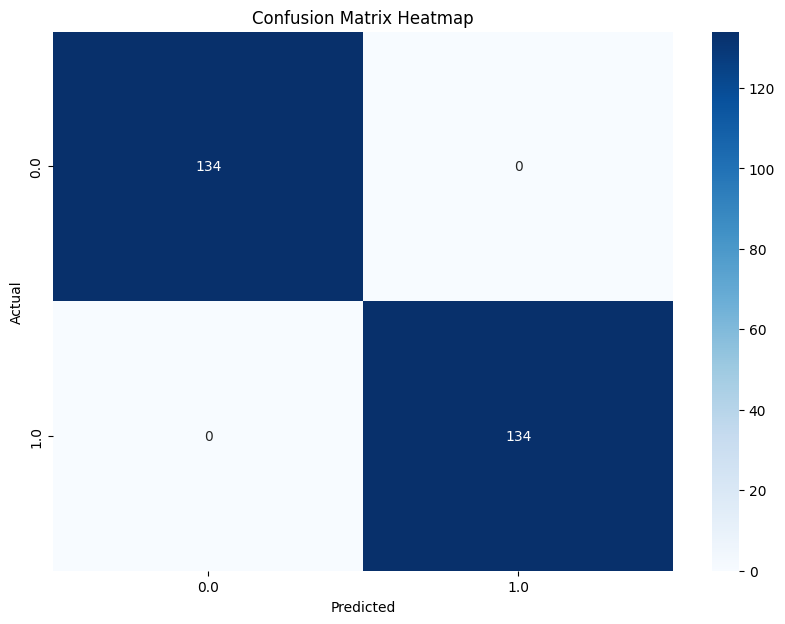

In [343]:
# Separate rows with known and unknown 'status'
df_known = df_union_all.dropna(subset=['status'])
df_unknown = df_union_all[df_union_all['status'].isna()]

# Prepare training data
X_train = df_known.drop('status', axis=1)
y_train = df_known['status']

# Prepare test data (features only for prediction)
X_test = df_unknown.drop('status', axis=1)

# Convert categorical features to numerical
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict Missing Values
y_pred = rf.predict(X_test)

# Extract country_name and country_code from status_pred
country_info = status_pred[['country_name', 'country_code']]

# Add predictions to the country_info DataFrame
country_info['status'] = y_pred

# Display the result
print(country_info.head())

# Update Original DataFrame
df_union_all.loc[df_union_all['status'].isna(), 'status'] = y_pred

# Evaluate the model on known data
y_pred_known = rf.predict(X_train)
print("Accuracy on known data:", accuracy_score(y_train, y_pred_known))
print("Classification Report on known data:\n", classification_report(y_train, y_pred_known))
# Generate Confusion Matrix
cm = confusion_matrix(y_train, y_pred_known)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


## Prediction Eco status value

In [344]:
# Extract country_name and country_code from status_pred
country_info = status_pred[['country_name', 'country_code']]

# Add predictions to the country_info DataFrame
country_info['status'] = y_pred
country_info.loc[country_info['country_code'] == 'USA', 'status'] = country_info.loc[country_info['country_code'] == 'USA', 'status'].replace(0, 1)

# Display the result
country_info


<ipython-input-344-bee950ea8a26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_info['status'] = y_pred


,country_name,country_code,status
0,Andorra,AND,0.0
1,Aruba,ABW,0.0
2,The Bahamas,BHS,0.0
3,Bolivia,BOL,0.0
4,Democratic Republic of the Congo,COD,0.0
5,Republic of the Congo,COG,0.0
6,Côte d'Ivoire,CIV,0.0
7,Curacao,CUW,0.0
8,Egypt,EGY,0.0
9,Eswatini,SWZ,0.0


In [345]:
feature_eng2['status'].replace('nan',np.nan, inplace=True)


In [346]:
feature_eng2.isna().sum()

,0
country_name,0
country_code,0
status,33
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [347]:
feature_eng2

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,population_15_64_total,consumer_price_index_2010,inflation_annual%,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd
0,Afghanistan,AFG,0.0,85.3,1.010000e+12,62.880,12.26,-1.18,43.13,984763,22404909,156.810,7.95,1.450216e+10,-6.24,352.60,54.51,1.45,7.745430e+07
1,Albania,ALB,0.0,100.0,1.770000e+12,76.830,38.68,-0.41,16.15,462629,1866557,131.750,6.73,1.891638e+10,4.86,6810.11,47.75,1.58,8.864110e+05
2,Algeria,DZA,0.0,100.0,2.640000e+13,77.130,28.30,-0.64,30.64,2868322,28275097,181.620,9.27,2.260000e+11,3.60,5023.25,20.39,4.78,7.745430e+07
3,Andorra,AND,NaN,100.0,1.335000e+12,73.045,88.68,1.27,12.80,11948,57663,142.415,8.00,3.380602e+09,9.56,42350.70,47.81,1.46,4.339834e+07
4,Angola,AGO,0.0,48.5,1.470000e+12,61.930,30.66,-0.60,45.02,925334,18643225,708.320,21.36,1.040000e+11,3.05,2933.48,25.30,1.33,7.720446e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,"Venezuela,_RB",VEN,NaN,100.0,1.335000e+12,71.100,1.89,-1.65,27.57,2436358,18061363,142.415,8.00,4.279849e+10,4.13,6913.05,47.81,0.65,3.221220e+08
192,Viet_Nam,VNM,0.0,100.0,5.820000e+15,74.580,45.75,-0.29,22.39,8951655,67251030,177.310,3.16,4.100000e+11,8.12,4179.01,89.98,1.45,1.230000e+11
193,"Yemen,_Rep.",YEM,NaN,76.0,1.335000e+12,63.720,1.42,-1.68,39.50,897081,19490300,142.415,8.00,4.279849e+10,4.13,698.85,47.81,1.46,3.221220e+08
194,Zambia,ZMB,0.0,47.8,1.710000e+12,61.800,34.43,-0.53,42.86,349807,11088982,332.780,10.99,2.916378e+10,5.25,1456.90,29.10,1.19,1.123747e+07


In [348]:
feature_eng2['status'].value_counts(dropna=False)

,count
status,
0.0,134
NaN,33
1.0,29


In [349]:
# Assuming feature_eng2 and country_info are your DataFrames
merged_df = feature_eng2.merge(country_info[['country_code', 'status']], on='country_code', how='left', suffixes=('', '_from_country_info'))

# Fill missing values in feature_eng2['status'] using values from merged_df['status_from_country_info']
feature_eng2['status'] = feature_eng2['status'].fillna(merged_df['status_from_country_info'])


In [350]:
feature_eng2['status'] = feature_eng2['status'].astype(float)

In [351]:
feature_eng2['status'].value_counts(dropna=False)

,count
status,
0.0,161
1.0,35


In [352]:
feature_eng2_chg = {'Bahamas, The':'The Bahamas','Viet Nam': 'Vietnam', 'Yemen, Rep.': 'Yemen','Venezuela, RB':'Venezuela','Turkiye':'Turkey','Slovak Republic':'Slovakia',
                    'Russian Federation':'Russia',"Korea, Dem. People's Rep.":'North Korea','Korea, Rep.':'South Korea', 'Lao PDR':'Laos','Iran, Islamic Rep.':'Iran',
                    'Congo, Rep.':'Republic of the Congo','Micronesia, Fed. Sts.':'Micronesia','Kyrgyz Republic':'Kyrgyzstan',"Côte d'Ivoire":"Cote d'Ivoire",
                    'Hong Kong SAR, China':'Hong Kong','Brunei Darussalam':'Brunei','Egypt, Arab Rep.':'Egypt','Gambia, The': 'The Gambia','Syrian Arab Republic':'Syria'}
feature_eng2['country_name'] = feature_eng2['country_name'].replace(feature_eng2_chg)


In [353]:
feature_eng2['country_name'] = feature_eng2['country_name'].str.replace('_',' ')
# Assuming feature_eng2 and freedom_df are your DataFrames
try_df = pd.merge(feature_eng2, freedom_df, on='country_name', how='left')


In [354]:
try_df.isnull().sum()

,0
country_name,0
country_code,0
status,0
access_to_electricity,0
gross_domestic_income,0
life_expectancy,0
control_of_corruption_percentile,0
control_of_corruption_estimate,0
population_0_14%,0
population_65_above_total,0


In [355]:
try_df[try_df['total_freedom_score'].isna()]

,country_name,country_code,status,access_to_electricity,gross_domestic_income,life_expectancy,control_of_corruption_percentile,control_of_corruption_estimate,population_0_14%,population_65_above_total,...,gdp_current_usd,gdp_growth_annual%,gdp_per_capita_current_usd,imports_%gdp,military_expenditure_%gdp,high_technology_exports_usd,freedom_status,political_rights,civil_liberties,total_freedom_score
8,Aruba,ABW,0.0,99.9,1.335000e+12,74.990,77.83,0.76,16.24,17182,...,3.544708e+09,10.46,33300.84,77.33,1.46,1.735161e+06,NaN,NaN,NaN,NaN
12,"Bahamas, The",BHS,0.0,100.0,1.185925e+10,74.360,84.43,1.26,19.06,36452,...,1.313640e+10,10.78,32041.25,43.75,1.46,0.000000e+00,NaN,NaN,NaN,NaN
25,Brunei Darussalam,BRN,0.0,100.0,2.157531e+10,74.550,83.96,1.17,22.06,27708,...,1.668154e+10,-1.63,37152.48,60.58,2.37,2.842223e+07,NaN,NaN,NaN,NaN
39,"Congo, Dem. Rep.",COD,0.0,21.5,2.230000e+13,59.740,3.30,-1.54,46.54,2891552,...,6.580155e+10,8.92,664.59,48.23,0.58,1.759753e+07,NaN,NaN,NaN,NaN
40,"Congo, Rep.",COG,0.0,50.6,4.030000e+12,63.050,7.08,-1.36,41.05,162448,...,1.581703e+10,1.48,2649.23,34.35,1.85,3.221220e+08,NaN,NaN,NaN,NaN
42,Cote d'Ivoire,CIV,0.0,70.4,3.850000e+13,58.920,42.45,-0.35,41.48,674709,...,7.017314e+10,6.22,2491.90,28.90,0.89,5.837225e+07,NaN,NaN,NaN,NaN
45,Curacao,CUW,0.0,100.0,1.335000e+12,73.045,46.23,-0.28,17.15,22424,...,3.073840e+09,7.90,20492.82,47.81,1.46,3.221220e+08,NaN,NaN,NaN,NaN
53,"Egypt, Arab Rep.",EGY,0.0,100.0,7.840000e+12,70.160,26.42,-0.68,32.86,5365058,...,4.770000e+11,6.59,4295.41,21.90,1.06,6.389509e+08,NaN,NaN,NaN,NaN
64,"Gambia, The",GMB,0.0,65.4,6.750493e+10,62.910,46.23,-0.28,43.06,65650,...,2.175100e+09,4.92,803.81,30.97,0.69,3.221220e+08,NaN,NaN,NaN,NaN
76,"Hong Kong SAR, China",HKG,1.0,100.0,2.750000e+12,83.660,92.45,1.61,12.04,1503940,...,3.590000e+11,-3.68,48828.12,190.39,1.46,1.940000e+11,NaN,NaN,NaN,NaN


In [356]:
word = 'ongo'
# For freedom_df
print(freedom_df[freedom_df['country_name'].str.contains(word)]['country_name'])

# For feature_eng2
print(feature_eng2[feature_eng2['country_name'].str.contains(word)]['country_name'])


45     Democratic Republic of the Congo
117                            Mongolia
147               Republic of the Congo
Name: country_name, dtype: object
39     Congo, Dem. Rep.
40          Congo, Rep.
118            Mongolia
Name: country_name, dtype: object


In [362]:
for column in try_df.loc[:, try_df.columns[-3:]]:
    mean_value = try_df.loc[try_df['status'] == 0, column].mean()
    try_df.loc[try_df['status'] == 0, column] = try_df.loc[try_df['status'] == 0, column].fillna(mean_value)
    mean_value = try_df.loc[try_df['status'] == 1, column].mean()
    try_df.loc[try_df['status'] == 1, column] = try_df.loc[try_df['status'] == 1, column].fillna(mean_value)

In [369]:
try_df['freedom_status'] = try_df.apply(
    lambda row: 'Free' if pd.isna(row['freedom_status']) and row['total_freedom_score'] >= 66 else
                'Partly Free' if pd.isna(row['freedom_status']) and row['total_freedom_score'] >= 33 else
                'Not Free' if pd.isna(row['freedom_status']) and row['total_freedom_score'] >= 0 else
                row['freedom_status'], axis=1
)

In [366]:
try_df['freedom_status'].unique()

array(['Not Free', 'Partly Free', 'Free', nan], dtype=object)

In [371]:
from google.colab import files
try_df.to_csv('cleansed_data.csv', index=False)
files.download('cleansed_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
freedom.sta